In [288]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from feature_engine.encoding import (
    OrdinalEncoder,
    CountFrequencyEncoder,
    RareLabelEncoder
)

# import train_test_split
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.feature_selection import VarianceThreshold

In [289]:
url = 'dataset/train.csv'
train = pd.read_csv(url)
test = pd.read_csv('dataset/test.csv')
train.head()

,ID,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income
0,478,1992,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,>50K
1,479,1981,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,<=50K
2,480,2004,NaN,122244,SMA Grad,SMA Grad,Belum-menikah,NaN,Tidak dalam Keluarga,1,Female,0,0,28,United-States,0,<=50K
3,481,1984,Pemerintah daerah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,<=50K
4,482,2000,Swasta,113936,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,1,Male,0,0,40,United-States,0,<=50K


## Data Preprocessing

In [290]:
# Dropping unnecessary column
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)
train.head(2)

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income
0,1992,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,>50K
1,1981,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,<=50K


In [291]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)
    
    missing_data = df.isnull().sum().sum()
    
    print(f'There are {missing_data} missing values in the dataset.')
    print(f'There are {df.duplicated().sum().sum()} duplicated values in the dataset.')
    print('-' *50)
    
    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))
        print('-' *50)


In [292]:
check_data(train)

--------------------------------------------------
There are 2956 missing values in the dataset.
There are 35 duplicated values in the dataset.
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Tahun Kelahiran          0
fnlwgt                   0
Pendidikan               0
Jenjang Pendidikan       0
Status                   0
Hubungan                 0
Etnis                    0
sex                      0
pendapatan               0
pengeluaran              0
hours per week           0
Asal Negara              0
jumlah_anak              0
income                   0
dtype: int64
--------------------------------------------------


## Feature Engineering

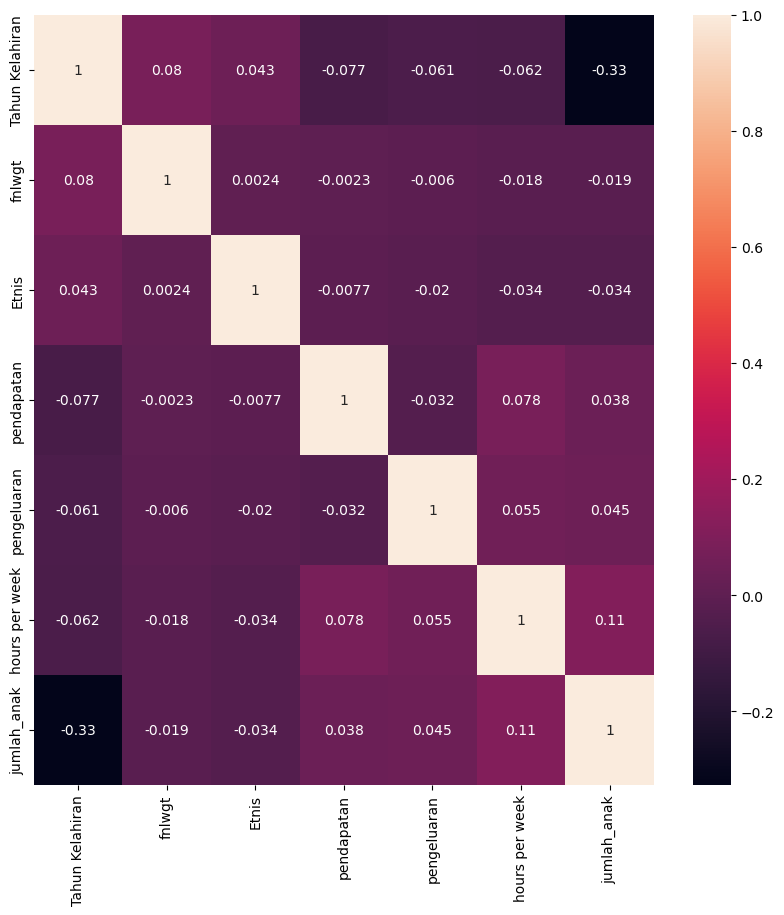

In [293]:
num_cols = [var for var in train.columns if train[var].dtypes != 'O']
corr_mat = train[num_cols].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot=True)
plt.show()

Not using linear based model

### Fixing data format

In [294]:
cat_cols = [var for var in train.columns if train[var].dtypes == 'O']

for col in train[cat_cols]:
    print(f'{col}: {train[col].unique()}')
    print('-' *50)

Kelas Pekerjaan: ['Swasta' nan 'Pemerintah daerah' 'Pengusaha berbadan hukum'
 'Pemerintah pusat' 'Pengusaha perorangan' 'Pemerintah negara'
 'Tanpa bayaran' 'Tidak bekerja']
--------------------------------------------------
Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Diploma' 'Asosiasi akademik' 'kelas 10'
 'kelas 9' 'kelas 7-8' 'Asosiasi vokasional' 'kelas 11' 'kelas 5-6'
 'Proffesor' 'kelas 12' 'Doktor' 'kelas 1-4' 'TK']
--------------------------------------------------
Jenjang Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Kuliah' 'vokasi Grad_1' 'SMA_1' 'SMP_2'
 'SMP_1' 'vokasi Grad_2' 'SMA_2' 'SD_2' 'Doktor' 'SMA_3' 'Proffesor'
 'SD_1' 'TK']
--------------------------------------------------
Status: ['Menikah' 'Belum-menikah' 'Cerai' 'Duda/Janda' 'Rencana Cerai'
 'Menikahi tentara' 'LDM']
--------------------------------------------------
Pekerjaan: ['Eksekutif Manager' nan 'Transportasi dan Pengangkutan'
 'Spesialis Profesional' 'Dukungan Teknis' 'Pekerjaan Kerajinan' 'Sales'

Fixing `Pendidikan` column

In [295]:
train['Pendidikan'].value_counts()

Pendidikan
SMA Grad               8387
Diploma                5820
Sarjana                4261
Magister               1407
Asosiasi vokasional    1111
kelas 11                933
Asosiasi akademik       876
kelas 10                729
kelas 7-8               526
Proffesor               462
kelas 9                 409
kelas 12                354
Doktor                  330
kelas 5-6               282
kelas 1-4               140
TK                       42
Name: count, dtype: int64

In [296]:
# replace kelas 10, kelas 11, kelas 12 with SMA
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 10', 'kelas 11', 'kelas 12'], 'SMA')
test['Pendidikan'] = test['Pendidikan'].replace(['kelas 10', 'kelas 11', 'kelas 12'], 'SMA')

# replace kelas 7-8, kelas 9 with SMP
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 7-8', 'kelas 9'], 'SMP')
test['Pendidikan'] = test['Pendidikan'].replace(['kelas 7-8', 'kelas 9'], 'SMP')

# replace kelas 1-4, kelas 5-6 with SD
train['Pendidikan'] = train['Pendidikan'].replace(['kelas 1-4', 'kelas 5-6'], 'SD')
test['Pendidikan'] = test['Pendidikan'].replace(['kelas 1-4', 'kelas 5-6'], 'SD')

# # replace
# train['Pendidikan'] = train['Pendidikan'].replace(['Diploma', 'Asosiasi akademik', 'Asosiasi vokasional',
#                                                    'Sarjana', 'Magister', 'Doktor', 'Proffesor', 'SMA Grad'], 'Pendidikan Tinggi')
train['Pendidikan'].value_counts()

Pendidikan
SMA Grad               8387
Diploma                5820
Sarjana                4261
SMA                    2016
Magister               1407
Asosiasi vokasional    1111
SMP                     935
Asosiasi akademik       876
Proffesor               462
SD                      422
Doktor                  330
TK                       42
Name: count, dtype: int64

Fixing `Status` column

In [297]:
train['Status'].value_counts()

Status
Menikah             12012
Belum-menikah        8505
Cerai                3564
Rencana Cerai         826
Duda/Janda            812
LDM                   332
Menikahi tentara       18
Name: count, dtype: int64

In [298]:
train['Status'] = train['Status'].replace(['Menikahi tentara', 'LDM'], 'Menikah')
test['Status'] = test['Status'].replace(['Menikahi tentara', 'LDM'], 'Menikah')

# replacing menikahi tentara with Menikah

train['Status'].value_counts()

Status
Menikah          12362
Belum-menikah     8505
Cerai             3564
Rencana Cerai      826
Duda/Janda         812
Name: count, dtype: int64

Fixing `Hubungan` column (**PENDING)

In [299]:
train['Hubungan'].value_counts()

Hubungan
Suami                   10598
Tidak dalam Keluarga     6675
Punya Anak               4036
Belum Menikah            2736
Istri                    1233
Kerabat                   791
Name: count, dtype: int64

Fixing `Kelas Pekerjaan` column

In [300]:
train['Kelas Pekerjaan'].value_counts()

Kelas Pekerjaan
Swasta                      18114
Pengusaha perorangan         2043
Pemerintah daerah            1705
Pemerintah negara            1053
Pengusaha berbadan hukum      894
Pemerintah pusat              766
Tanpa bayaran                  13
Tidak bekerja                   6
Name: count, dtype: int64

In [301]:
# replacing with sektor pemerintah affiliated
train['Kelas Pekerjaan'] = train['Kelas Pekerjaan'].replace(['Pemerintah pusat', 'Pemerintah daerah',
                                                             'Pemerintah negara'], 'Sektor Pemerintah')
test['Kelas Pekerjaan'] = test['Kelas Pekerjaan'].replace(['Pemerintah pusat', 'Pemerintah daerah',
                                                             'Pemerintah negara'], 'Sektor Pemerintah')

# train['Kelas Pekerjaan'] = train['Kelas Pekerjaan'].replace(['Tanpa bayaran', 'Tidak bekerja'], '')

train['Kelas Pekerjaan'].value_counts()

Kelas Pekerjaan
Swasta                      18114
Sektor Pemerintah            3524
Pengusaha perorangan         2043
Pengusaha berbadan hukum      894
Tanpa bayaran                  13
Tidak bekerja                   6
Name: count, dtype: int64

In [302]:
# no_income feature column
train['no_income'] = train['Kelas Pekerjaan'].apply(lambda x: 1 if x == 'Tanpa bayaran' or x == 'Tidak bekerja' else 0)
test['no_income'] = test['Kelas Pekerjaan'].apply(lambda x: 1 if x == 'Tanpa bayaran' or x == 'Tidak bekerja' else 0)

train['no_income'].value_counts()

no_income
0    26050
1       19
Name: count, dtype: int64

Fixing `Jenjang Pendidikan` column

In [303]:
train['Jenjang Pendidikan'].value_counts()

Jenjang Pendidikan
SMA Grad         8387
Kuliah           5820
Sarjana          4261
Magister         1407
vokasi Grad_2    1111
SMA_2             933
vokasi Grad_1     876
SMA_1             729
SMP_1             526
Doktor            462
SMP_2             409
SMA_3             354
Proffesor         330
SD_2              282
SD_1              140
TK                 42
Name: count, dtype: int64

In [304]:
# replace SMA_1, SMA_2, SMA_3 with SMA
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SMA_1', 'SMA_2', 'SMA_3'], 'SMA')
test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].replace(['SMA_1', 'SMA_2', 'SMA_3'], 'SMA')

# replace SMP_1, SMP_2, SMP_3 with SMP
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SMP_1', 'SMP_2', 'SMP_3'], 'SMP')
test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].replace(['SMP_1', 'SMP_2', 'SMP_3'], 'SMP')

# replace SD_1, SD_2, with SD
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['SD_1', 'SD_2'], 'SD')
test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].replace(['SD_1', 'SD_2'], 'SD')

# replace vokasi Grad_1, vokasi Grad_2 with vokasi Grad
train['Jenjang Pendidikan'] = train['Jenjang Pendidikan'].replace(['vokasi Grad_1', 'vokasi Grad_2'], 'Vokasi Grad')
test['Jenjang Pendidikan'] = test['Jenjang Pendidikan'].replace(['vokasi Grad_1', 'vokasi Grad_2'], 'Vokasi Grad')

train['Jenjang Pendidikan'].value_counts()

Jenjang Pendidikan
SMA Grad       8387
Kuliah         5820
Sarjana        4261
SMA            2016
Vokasi Grad    1987
Magister       1407
SMP             935
Doktor          462
SD              422
Proffesor       330
TK               42
Name: count, dtype: int64

Fixing `Asal Negara` column

In [305]:
train['Asal Negara'].value_counts()

Asal Negara
United-States                 23355
Mexico                          532
?                               458
Philippines                     157
Germany                         109
Canada                           93
Puerto-Rico                      92
El-Salvador                      85
Cuba                             83
India                            82
England                          69
South                            68
China                            61
Jamaica                          60
Italy                            60
Dominican-Republic               58
Vietnam                          52
Poland                           48
Columbia                         48
Japan                            46
Taiwan                           44
Guatemala                        43
Haiti                            36
Iran                             31
Portugal                         30
France                           27
Greece                           25
Ecuador         

In [306]:
# replace ? with missing value
train['Asal Negara'] = train['Asal Negara'].replace(['?'], np.nan)
test['Asal Negara'] = test['Asal Negara'].replace(['?'], np.nan)

# replace "Hong" with "Hong Kong"
train['Asal Negara'] = train['Asal Negara'].replace(['Hong'], 'Hong Kong')
test['Asal Negara'] = test['Asal Negara'].replace(['Hong'], 'Hong Kong')

train['Asal Negara'].value_counts()

Asal Negara
United-States                 23355
Mexico                          532
Philippines                     157
Germany                         109
Canada                           93
Puerto-Rico                      92
El-Salvador                      85
Cuba                             83
India                            82
England                          69
South                            68
China                            61
Jamaica                          60
Italy                            60
Dominican-Republic               58
Vietnam                          52
Columbia                         48
Poland                           48
Japan                            46
Taiwan                           44
Guatemala                        43
Haiti                            36
Iran                             31
Portugal                         30
France                           27
Ecuador                          25
Greece                           25
Peru            

In [307]:
cat_cols = [var for var in train.columns if train[var].dtypes == 'O']

for col in train[cat_cols]:
    print(f'{col}: {train[col].unique()}')
    print('-' *50)

Kelas Pekerjaan: ['Swasta' nan 'Sektor Pemerintah' 'Pengusaha berbadan hukum'
 'Pengusaha perorangan' 'Tanpa bayaran' 'Tidak bekerja']
--------------------------------------------------
Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Diploma' 'Asosiasi akademik' 'SMA' 'SMP'
 'Asosiasi vokasional' 'SD' 'Proffesor' 'Doktor' 'TK']
--------------------------------------------------
Jenjang Pendidikan: ['Sarjana' 'Magister' 'SMA Grad' 'Kuliah' 'Vokasi Grad' 'SMA' 'SMP' 'SD'
 'Doktor' 'Proffesor' 'TK']
--------------------------------------------------
Status: ['Menikah' 'Belum-menikah' 'Cerai' 'Duda/Janda' 'Rencana Cerai']
--------------------------------------------------
Pekerjaan: ['Eksekutif Manager' nan 'Transportasi dan Pengangkutan'
 'Spesialis Profesional' 'Dukungan Teknis' 'Pekerjaan Kerajinan' 'Sales'
 'Layanan Lainnya' 'Pengelola Kebersihan' 'Inspeksi dan Operasi Mesin'
 'Pertanian dan Perikanan' 'Administratif dan Kantor'
 'Layanan Perlindungan' 'Pembantu Rumah Tangga' 'Angkatan B

In [308]:
# train 2 ini untuk encode manual
train_2 = train.copy() 

In [309]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)

    missing_data = df.isnull().sum().sum()
    print('Missing data:', missing_data)

    duplicated_data = df.duplicated().sum().sum()
    print('Duplicated data:', duplicated_data)

    print('-' *50)

    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))

    print('-' *50)

check_data(train_2)

--------------------------------------------------
Missing data: 3414
Duplicated data: 36
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Asal Negara            458
Tahun Kelahiran          0
pendapatan               0
income                   0
jumlah_anak              0
hours per week           0
pengeluaran              0
Etnis                    0
sex                      0
Hubungan                 0
Status                   0
Jenjang Pendidikan       0
Pendidikan               0
fnlwgt                   0
no_income                0
dtype: int64
--------------------------------------------------


In [310]:
train.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,Swasta,37210,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,0,45,United-States,2,>50K,0
1,1981,Swasta,101950,Magister,Magister,Belum-menikah,Eksekutif Manager,Tidak dalam Keluarga,1,Female,0,0,45,United-States,0,<=50K,0
2,2004,NaN,122244,SMA Grad,SMA Grad,Belum-menikah,NaN,Tidak dalam Keluarga,1,Female,0,0,28,United-States,0,<=50K,0
3,1984,Sektor Pemerintah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,<=50K,0
4,2000,Swasta,113936,Sarjana,Sarjana,Belum-menikah,Spesialis Profesional,Punya Anak,1,Male,0,0,40,United-States,0,<=50K,0


## Engineering inconsistent data

Hubungan column

In [311]:
train[(train['Hubungan'] == 'Tidak dalam Keluarga') & (train['Status'] == 'Cerai')]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
26,1990,Swasta,29235,Asosiasi akademik,Vokasi Grad,Cerai,Spesialis Profesional,Tidak dalam Keluarga,1,Female,0,0,40,United-States,3,<=50K,0
43,1977,Swasta,105381,SMA Grad,SMA Grad,Cerai,Sales,Tidak dalam Keluarga,1,Female,0,0,40,United-States,2,<=50K,0
44,1987,Swasta,348796,Sarjana,Sarjana,Cerai,Layanan Lainnya,Tidak dalam Keluarga,1,Male,0,0,40,United-States,1,<=50K,0
45,1977,Swasta,187969,SMA,SMA,Cerai,Layanan Lainnya,Tidak dalam Keluarga,1,Female,0,0,38,United-States,1,<=50K,0
64,1991,Pengusaha perorangan,167476,SMA,SMA,Cerai,Pengelola Kebersihan,Tidak dalam Keluarga,1,Male,0,0,7,United-States,2,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26027,1991,Sektor Pemerintah,298785,SMA,SMA,Cerai,Transportasi dan Pengangkutan,Tidak dalam Keluarga,1,Male,0,0,40,United-States,0,<=50K,0
26031,1970,Swasta,235693,SMA,SMA,Cerai,Administratif dan Kantor,Tidak dalam Keluarga,1,Male,0,0,40,United-States,0,>50K,0
26047,2005,Swasta,415354,SMA,SMA,Cerai,Layanan Lainnya,Tidak dalam Keluarga,1,Female,0,0,40,United-States,3,<=50K,0
26048,1968,Swasta,444089,SMA,SMA,Cerai,Sales,Tidak dalam Keluarga,1,Female,0,0,40,United-States,3,<=50K,0


In [312]:
train[(train['Hubungan'] == 'Belum Menikah') & (train['Status'] == 'Rencana Cerai')]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
21,1990,Swasta,231238,SMP,SMP,Rencana Cerai,Pertanian dan Perikanan,Belum Menikah,2,Male,0,0,40,United-States,0,<=50K,0
267,1999,Swasta,212302,Diploma,Kuliah,Rencana Cerai,Administratif dan Kantor,Belum Menikah,1,Female,0,0,40,United-States,1,<=50K,0
355,1989,Swasta,193106,SMA Grad,SMA Grad,Rencana Cerai,Administratif dan Kantor,Belum Menikah,1,Female,0,0,32,United-States,1,<=50K,0
485,1982,Swasta,266710,Diploma,Kuliah,Rencana Cerai,Administratif dan Kantor,Belum Menikah,2,Female,0,0,41,United-States,2,<=50K,0
556,1988,Swasta,127809,SMA Grad,SMA Grad,Rencana Cerai,Layanan Lainnya,Belum Menikah,2,Female,0,0,30,United-States,3,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25714,1987,Pengusaha berbadan hukum,86459,Asosiasi akademik,Vokasi Grad,Rencana Cerai,Eksekutif Manager,Belum Menikah,1,Male,0,0,50,United-States,1,<=50K,0
25770,1980,Sektor Pemerintah,101950,Proffesor,Doktor,Rencana Cerai,Spesialis Profesional,Belum Menikah,1,Female,0,0,40,United-States,1,<=50K,0
25835,1980,Swasta,155701,SMP,SMP,Rencana Cerai,Layanan Lainnya,Belum Menikah,1,Female,0,0,38,Peru,3,<=50K,0
25895,1972,Sektor Pemerintah,38973,Sarjana,Sarjana,Rencana Cerai,Administratif dan Kantor,Belum Menikah,2,Female,0,0,40,United-States,2,<=50K,0


In [313]:
train[(train['Hubungan'] == 'Belum Menikah') & (train['Status'] == 'Duda/Janda')]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
32,1971,Swasta,355802,Diploma,Kuliah,Duda/Janda,Sales,Belum Menikah,1,Female,0,0,30,United-States,0,<=50K,0
340,1969,Swasta,256953,SMA Grad,SMA Grad,Duda/Janda,Inspeksi dan Operasi Mesin,Belum Menikah,2,Female,0,0,44,United-States,1,<=50K,0
492,1953,Sektor Pemerintah,365996,Sarjana,Sarjana,Duda/Janda,Spesialis Profesional,Belum Menikah,1,Female,0,0,6,United-States,0,<=50K,0
568,1993,Swasta,243605,Sarjana,Sarjana,Duda/Janda,Sales,Belum Menikah,1,Female,0,1380,40,Cuba,0,<=50K,0
722,1945,Sektor Pemerintah,146244,Doktor,Proffesor,Duda/Janda,Spesialis Profesional,Belum Menikah,1,Female,0,0,40,United-States,1,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25478,1970,Swasta,222882,SMA Grad,SMA Grad,Duda/Janda,Eksekutif Manager,Belum Menikah,1,Female,0,0,45,United-States,3,<=50K,0
25514,1968,Swasta,235205,SMA Grad,SMA Grad,Duda/Janda,Layanan Lainnya,Belum Menikah,1,Female,0,0,40,United-States,3,<=50K,0
25529,1964,NaN,116961,SMP,SMP,Duda/Janda,NaN,Belum Menikah,1,Female,0,0,20,United-States,3,<=50K,0
25911,1968,Swasta,659558,SMA,SMA,Duda/Janda,Layanan Lainnya,Belum Menikah,2,Female,0,0,40,United-States,0,<=50K,0


In [314]:
train[(train['Hubungan'] == 'Tidak dalam Keluarga') & (train['Status'] == 'Rencana Cerai')]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
20,1961,Swasta,175777,SMA,SMA,Rencana Cerai,Inspeksi dan Operasi Mesin,Tidak dalam Keluarga,2,Male,0,0,40,United-States,2,<=50K,0
277,1971,Swasta,126977,SMA Grad,SMA Grad,Rencana Cerai,Pekerjaan Kerajinan,Tidak dalam Keluarga,1,Male,0,0,35,United-States,2,<=50K,0
289,1978,Swasta,146919,SMA Grad,SMA Grad,Rencana Cerai,Sales,Tidak dalam Keluarga,1,Female,0,0,40,United-States,1,<=50K,0
370,1973,Swasta,110458,Sarjana,Sarjana,Rencana Cerai,Spesialis Profesional,Tidak dalam Keluarga,1,Male,0,0,40,United-States,1,<=50K,0
404,1992,Swasta,123429,SMA,SMA,Rencana Cerai,Pekerjaan Kerajinan,Tidak dalam Keluarga,1,Male,0,0,40,United-States,0,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25630,1976,Swasta,93476,SMA Grad,SMA Grad,Rencana Cerai,Administratif dan Kantor,Tidak dalam Keluarga,1,Female,0,2001,40,United-States,3,<=50K,0
25697,1998,Pengusaha perorangan,109609,Diploma,Kuliah,Rencana Cerai,Pekerjaan Kerajinan,Tidak dalam Keluarga,1,Male,0,0,30,United-States,3,<=50K,0
25816,1992,Swasta,192965,SMA Grad,SMA Grad,Rencana Cerai,Sales,Tidak dalam Keluarga,1,Female,0,0,45,United-States,1,<=50K,0
25827,1988,NaN,187167,SMA Grad,SMA Grad,Rencana Cerai,NaN,Tidak dalam Keluarga,1,Female,0,0,30,United-States,2,<=50K,0


In [315]:
train[(train['Hubungan'] == 'Belum Menikah') & (train['Status'] == 'Cerai')]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
3,1984,Sektor Pemerintah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,<=50K,0
93,1995,Swasta,93662,Diploma,Kuliah,Cerai,Spesialis Profesional,Belum Menikah,1,Female,0,0,24,United-States,0,<=50K,0
98,1967,Swasta,426263,Magister,Magister,Cerai,Eksekutif Manager,Belum Menikah,1,Male,0,0,40,United-States,1,>50K,0
115,1990,Swasta,216864,SMA Grad,SMA Grad,Cerai,Layanan Lainnya,Belum Menikah,1,Female,0,3770,45,United-States,0,<=50K,0
125,1990,Swasta,258170,SMA Grad,SMA Grad,Cerai,Eksekutif Manager,Belum Menikah,1,Female,0,0,38,United-States,1,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26009,1985,Sektor Pemerintah,193583,Sarjana,Sarjana,Cerai,Spesialis Profesional,Belum Menikah,1,Female,5455,0,60,United-States,0,<=50K,0
26024,1977,Swasta,97176,SMA Grad,SMA Grad,Cerai,Administratif dan Kantor,Belum Menikah,1,Female,0,0,40,United-States,3,<=50K,0
26044,1985,Swasta,421633,Diploma,Kuliah,Cerai,Layanan Perlindungan,Belum Menikah,2,Female,0,0,30,United-States,0,<=50K,0
26052,1984,Sektor Pemerintah,24763,Diploma,Kuliah,Cerai,Transportasi dan Pengangkutan,Belum Menikah,1,Male,6849,0,40,United-States,0,<=50K,0


In [316]:
train[(train['Hubungan'] == 'Punya ') & (train['Status'] == 'LDM')]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income


Pendapatan Column

In [317]:
train[(train['pendapatan'] == 0) & (train['pengeluaran'] > 0)]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
8,1980,Pengusaha berbadan hukum,191712,Magister,Magister,Menikah,Spesialis Profesional,Suami,1,Male,0,2415,55,United-States,2,>50K,0
19,1978,Swasta,148738,SMA Grad,SMA Grad,Menikah,Pengelola Kebersihan,Suami,1,Male,0,1740,35,United-States,2,<=50K,0
91,1979,Sektor Pemerintah,160472,Sarjana,Sarjana,Menikah,Eksekutif Manager,Suami,1,Male,0,1977,50,United-States,2,>50K,0
103,1995,Swasta,81648,SMA Grad,SMA Grad,Menikah,Sales,Suami,1,Male,0,1887,55,United-States,3,>50K,0
115,1990,Swasta,216864,SMA Grad,SMA Grad,Cerai,Layanan Lainnya,Belum Menikah,1,Female,0,3770,45,United-States,0,<=50K,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25794,1978,Swasta,74895,Asosiasi akademik,Vokasi Grad,Menikah,Pekerjaan Kerajinan,Suami,1,Male,0,1485,55,United-States,0,<=50K,0
25817,1979,Sektor Pemerintah,199590,Diploma,Kuliah,Menikah,Pekerjaan Kerajinan,Suami,1,Male,0,1887,40,Mexico,3,>50K,0
25894,2005,Swasta,240468,Diploma,Kuliah,Menikah,Sales,Punya Anak,1,Female,0,1602,40,United-States,1,<=50K,0
25968,1972,Swasta,143953,Sarjana,Sarjana,Menikah,Spesialis Profesional,Suami,1,Male,0,1902,40,United-States,1,>50K,0


In [318]:
train['pengeluaran'].value_counts()

pengeluaran
0       24845
1902      166
1977      139
1887      123
1485       41
        ...  
1539        1
2754        1
1411        1
2489        1
974         1
Name: count, Length: 88, dtype: int64

Feature engineering inconsistent data
- Hubungan & Status Column
    - `Belum Menikah` & `Cerai`
    - `Belum Menikah` & `Rencana Cerai`
    - `Belum Menikah` & `Duda/Janda`
    - `Tidak dalam Keluarga` & `Rencana Cerai`
    - `Tidak dalam Keluarga` & `Cerai`
    - `Tidak dalam Keluarga` & `Menikah`
- Hubungan & jumlah_anak
    - `Punya Anak` & `jumlah_anak == 0`
- Hubungan & Sex column
    - `Suami` & `Female`
    - `Istri` & `Male`

a. Hubungan & Sex Column

In [319]:
train[(train['Hubungan'] == 'Suami') & (train['sex'] == 'Female')]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
7879,1990,Swasta,175878,SMA Grad,SMA Grad,Menikah,Sales,Suami,1,Female,0,0,40,United-States,2,<=50K,0


In [320]:
train[(train['Hubungan'] == 'Istri') & (train['sex'] == 'Male')]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
3748,1988,Swasta,74791,Sarjana,Sarjana,Menikah,Sales,Istri,1,Male,0,0,60,NaN,1,<=50K,0
23443,1995,Swasta,350162,Sarjana,Sarjana,Menikah,Eksekutif Manager,Istri,1,Male,0,0,40,United-States,2,>50K,0


In [321]:
train['Hubungan'].value_counts()

Hubungan
Suami                   10598
Tidak dalam Keluarga     6675
Punya Anak               4036
Belum Menikah            2736
Istri                    1233
Kerabat                   791
Name: count, dtype: int64

In [322]:
train['sex'].value_counts()

sex
Male      17449
Female     8620
Name: count, dtype: int64

In [323]:
# update 'sex' to 'Female' where 'Hubungan' is 'Istri' and 'sex' is 'Male'
train.loc[(train['Hubungan'] == 'Istri') & (train['sex'] == 'Male'), 'sex'] = 'Female'

# update 'sex' to 'Male' where 'Hubungan' is 'Suami' and 'sex' is 'Female'
train.loc[(train['Hubungan'] == 'Suami') & (train['sex'] == 'Female'), 'sex'] = 'Male'

In [324]:
train['sex'].value_counts()

sex
Male      17448
Female     8621
Name: count, dtype: int64

b. Hubungan & jumlah_anak

In [325]:
train.loc[(train['Hubungan'] == 'Punya Anak') & (train['jumlah_anak'] > 0), 'jumlah_anak'] = np.nan
test.loc[(test['Hubungan'] == 'Punya Anak') & (test['jumlah_anak'] > 0), 'jumlah_anak'] = np.nan

train[(train['Hubungan'] == 'Punya Anak') & (train['jumlah_anak'] > 0)]

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income


In [326]:
test[(test['Hubungan'] == 'Punya Anak') & (test['jumlah_anak'] > 0)]


,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,no_income


c. Hubungan & Status Column

In [327]:
train['Hubungan'].value_counts()

Hubungan
Suami                   10598
Tidak dalam Keluarga     6675
Punya Anak               4036
Belum Menikah            2736
Istri                    1233
Kerabat                   791
Name: count, dtype: int64

In [328]:
train['Status'].value_counts()

Status
Menikah          12362
Belum-menikah     8505
Cerai             3564
Rencana Cerai      826
Duda/Janda         812
Name: count, dtype: int64

Belum Menikah & Cerai:
- replace status with Belum-Menikah

In [329]:
# replace 'Status' with 'Belum-menikah' where 'Hubungan' is 'Belum menikah' and 'Status' is 'Cerai'
train.loc[(train['Hubungan'] == 'Belum Menikah') & (train['Status'] == 'Cerai'), 'Status'] = 'Belum-menikah'
test.loc[(test['Hubungan'] == 'Belum Menikah') & (test['Status'] == 'Cerai'), 'Status'] = 'Belum-menikah'

# replace 'Status' with 'Belum-menikah' where 'Hubungan' is 'Belum menikah' and 'Status' is 'Rencana Cerai'
train.loc[(train['Hubungan'] == 'Belum Menikah') & (train['Status'] == 'Rencana Cerai'), 'Status'] = 'Belum-menikah'
test.loc[(test['Hubungan'] == 'Belum menikah') & (test['Status'] == 'Rencana Cerai'), 'Status'] = 'Belum-menikah'

# replace 'Status' with 'Belum-menikah' where 'Hubungan' is 'Belum menikah' and 'Status' is 'Duda/Janda'
train.loc[(train['Hubungan'] == 'Belum Menikah') & (train['Status'] == 'Duda/Janda'), 'Status'] = 'Belum-menikah'
test.loc[(test['Hubungan'] == 'Belum Menikah') & (test['Status'] == 'Duda/Janda'), 'Status'] = 'Belum-menikah'


In [330]:
train['Status'].value_counts()

Status
Menikah          12362
Belum-menikah    10440
Cerai             2303
Duda/Janda         506
Rencana Cerai      458
Name: count, dtype: int64

In [331]:
train['Hubungan'].value_counts()

Hubungan
Suami                   10598
Tidak dalam Keluarga     6675
Punya Anak               4036
Belum Menikah            2736
Istri                    1233
Kerabat                   791
Name: count, dtype: int64

Tidak dalam Keluarga: <br>
- `Tidak dalam Keluarga` & `Rencana Cerai`
- `Tidak dalam Keluarga` & `Cerai`
- `Tidak dalam Keluarga` & `Menikah`
- replace status with Belum-menikah

In [332]:
# replace 'Status' with 'Belum-menikah' where 'Hubungan' is 'Tidak dalam Keluarga' and 'Status' is 'Cerai'
train.loc[(train['Hubungan'] == 'Tidak dalam Keluarga') & (train['Status'] == 'Rencana Cerai'), 'Status'] = 'Belum-menikah'
test.loc[(test['Hubungan'] == 'Tidak dalam Keluarga') & (test['Status'] == 'Rencana Cerai'), 'Status'] = 'Belum-menikah'

# replace 'Status' with 'Belum-menikah' where 'Hubungan' is 'Tidak dalam Keluarga' and 'Status' is 'Rencana Cerai'
train.loc[(train['Hubungan'] == 'Tidak dalam Keluarga') & (train['Status'] == 'Cerai'), 'Status'] = 'Belum-menikah'
test.loc[(test['Hubungan'] == 'Tidak dalam Keluarga') & (test['Status'] == 'Cerai'), 'Status'] = 'Belum-menikah'

# replace 'Status' with 'Belum-menikah' where 'Hubungan' is 'Tidak dalam Keluarga' and 'Status' is 'Duda/Janda'
train.loc[(train['Hubungan'] == 'Tidak dalam Keluarga') & (train['Status'] == 'Menikah'), 'Status'] = 'Belum-menikah'
test.loc[(test['Hubungan'] == 'Tidak dalam Keluarga') & (test['Status'] == 'Menikah'), 'Status'] = 'Belum-menikah'

In [333]:
train['Status'].value_counts()

Status
Belum-menikah    12893
Menikah          12183
Duda/Janda         506
Cerai              362
Rencana Cerai      125
Name: count, dtype: int64

In [334]:
# replacing 'Duda/Janda', 'Belum-menikah', 'Cerai' with "Not in a relationship"
train['Status'] = train['Status'].replace(['Duda/Janda', 'Belum-menikah', 'Cerai'], "Not in a relationship")
test['Status'] = test['Status'].replace(['Duda/Janda', 'Belum-menikah', 'Cerai'], "Not in a relationship")


# replacing 'Menikah', 'Rencana Cerai', with "In a relationship"
train['Status'] = train['Status'].replace(['Menikah', 'Rencana Cerai'], "In a relationship")
test['Status'] = test['Status'].replace(['Menikah', 'Rencana Cerai'], "In a relationship")

**Plan**:
- Make into 'In a relationship' & 'Not in a relationship' in `Status` column
- Handle `Pendapatan` & `Pengeluaran` high cardinality columns

Handling missing values

<Axes: >

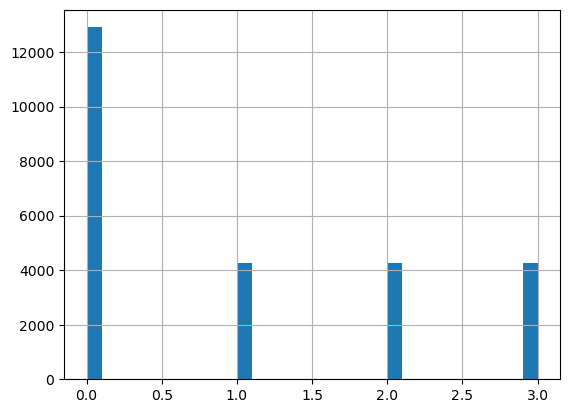

In [335]:
train['jumlah_anak'].hist(bins=30)

In [336]:
# fill jumlah_anak with median (skewed right)
train['jumlah_anak'].fillna(train['jumlah_anak'].median(), inplace=True)
test['jumlah_anak'].fillna(test['jumlah_anak'].median(), inplace=True)

check_data(train)

--------------------------------------------------
Missing data: 3414
Duplicated data: 36
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Asal Negara            458
Tahun Kelahiran          0
pendapatan               0
income                   0
jumlah_anak              0
hours per week           0
pengeluaran              0
Etnis                    0
sex                      0
Hubungan                 0
Status                   0
Jenjang Pendidikan       0
Pendidikan               0
fnlwgt                   0
no_income                0
dtype: int64
--------------------------------------------------


In [337]:
train['jumlah_anak'].isna().sum()

0

<Axes: >

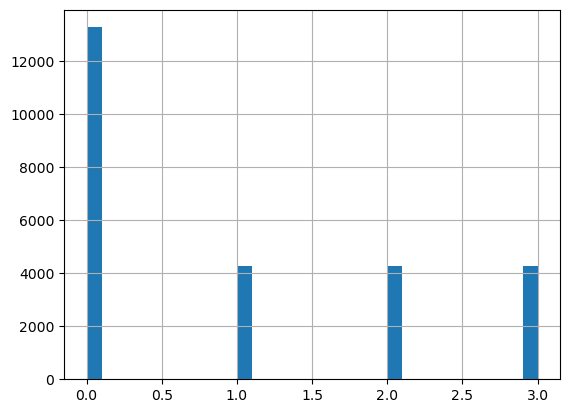

In [338]:
train['jumlah_anak'].hist(bins=30)

<Axes: xlabel='Kelas Pekerjaan'>

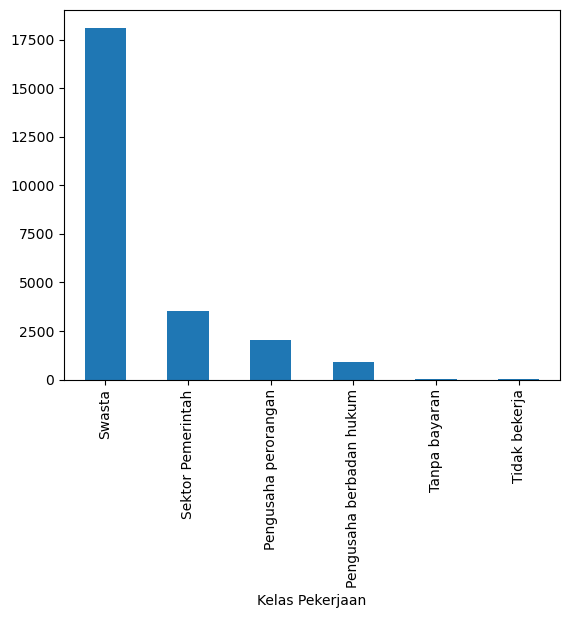

In [339]:
train['Kelas Pekerjaan'].value_counts().plot(kind='bar')

<Axes: xlabel='Pekerjaan'>

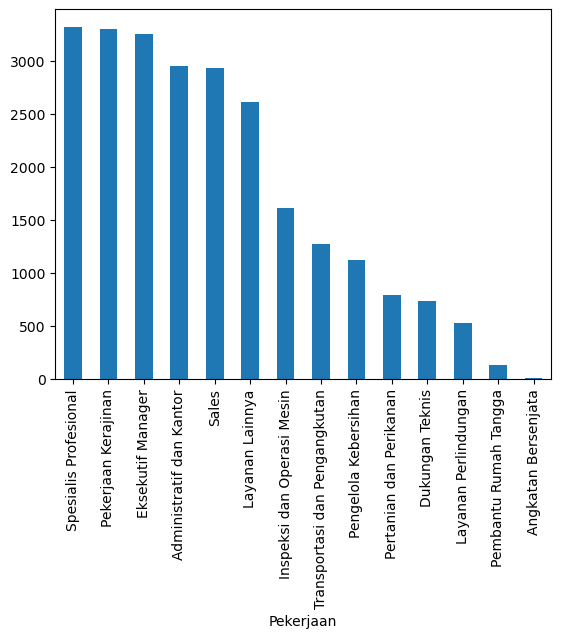

In [340]:
train['Pekerjaan'].value_counts().plot(kind='bar')

In [341]:
check_data(train)

--------------------------------------------------
Missing data: 3414
Duplicated data: 36
--------------------------------------------------
Missing values:
Pekerjaan             1481
Kelas Pekerjaan       1475
Asal Negara            458
Tahun Kelahiran          0
pendapatan               0
income                   0
jumlah_anak              0
hours per week           0
pengeluaran              0
Etnis                    0
sex                      0
Hubungan                 0
Status                   0
Jenjang Pendidikan       0
Pendidikan               0
fnlwgt                   0
no_income                0
dtype: int64
--------------------------------------------------


In [342]:
# fill missing values with the mode
train['Pekerjaan'].fillna(train['Pekerjaan'].mode()[0], inplace=True)
train['Kelas Pekerjaan'].fillna(train['Kelas Pekerjaan'].mode()[0], inplace=True)
train['Asal Negara'].fillna(train['Asal Negara'].mode()[0], inplace=True)

test['Pekerjaan'].fillna(test['Pekerjaan'].mode()[0], inplace=True)
test['Kelas Pekerjaan'].fillna(test['Kelas Pekerjaan'].mode()[0], inplace=True)
test['Asal Negara'].fillna(test['Asal Negara'].mode()[0], inplace=True)

In [343]:
check_data(train)

--------------------------------------------------
Missing data: 0
Duplicated data: 36
--------------------------------------------------
--------------------------------------------------


In [344]:
check_data(test)

--------------------------------------------------
Missing data: 0
Duplicated data: 1
--------------------------------------------------
--------------------------------------------------


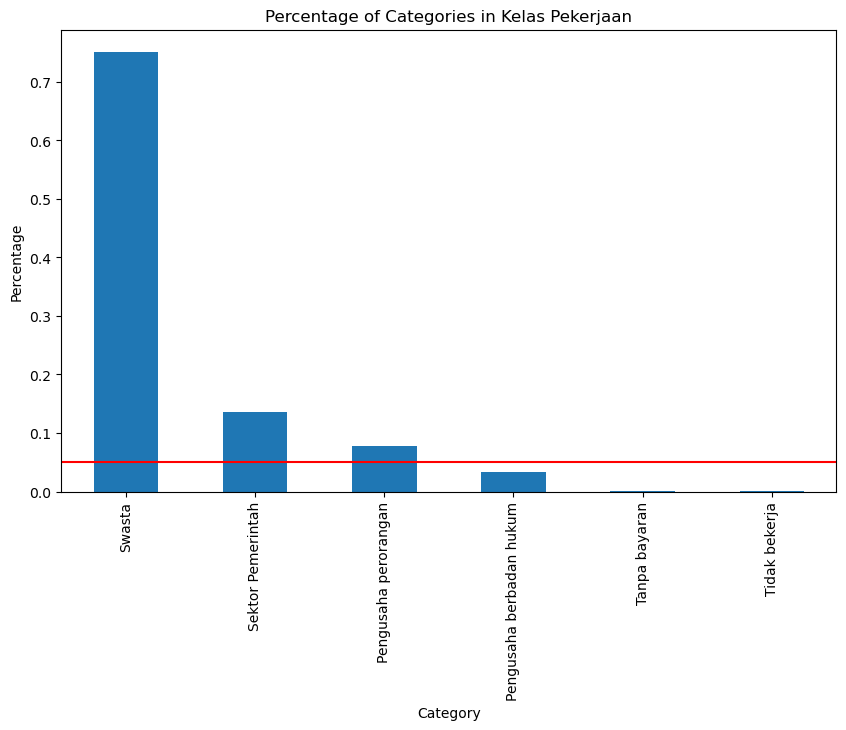

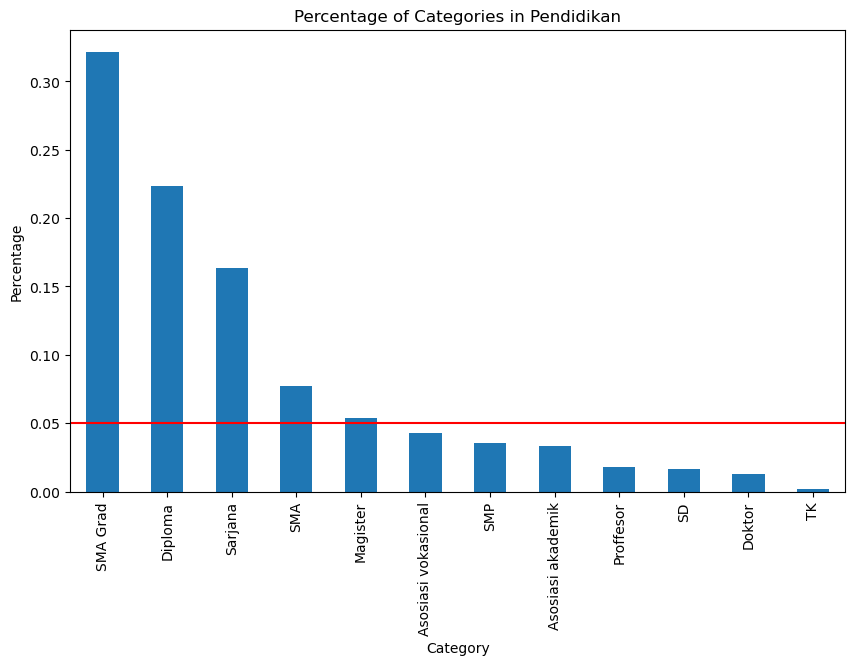

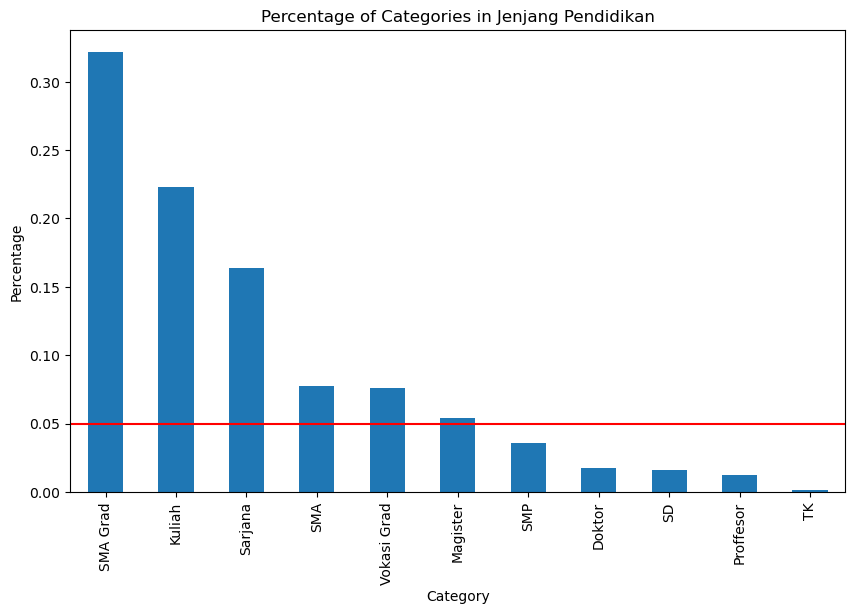

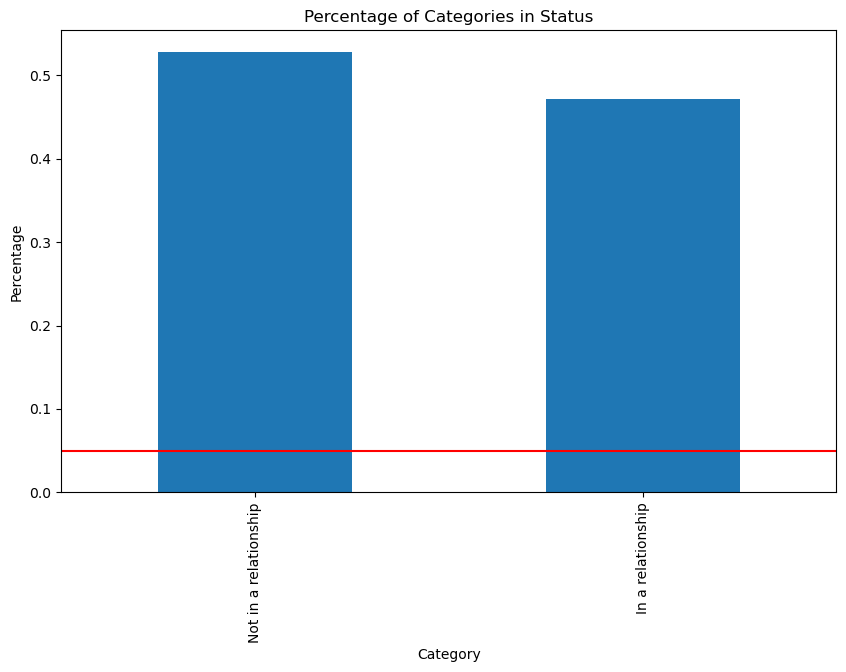

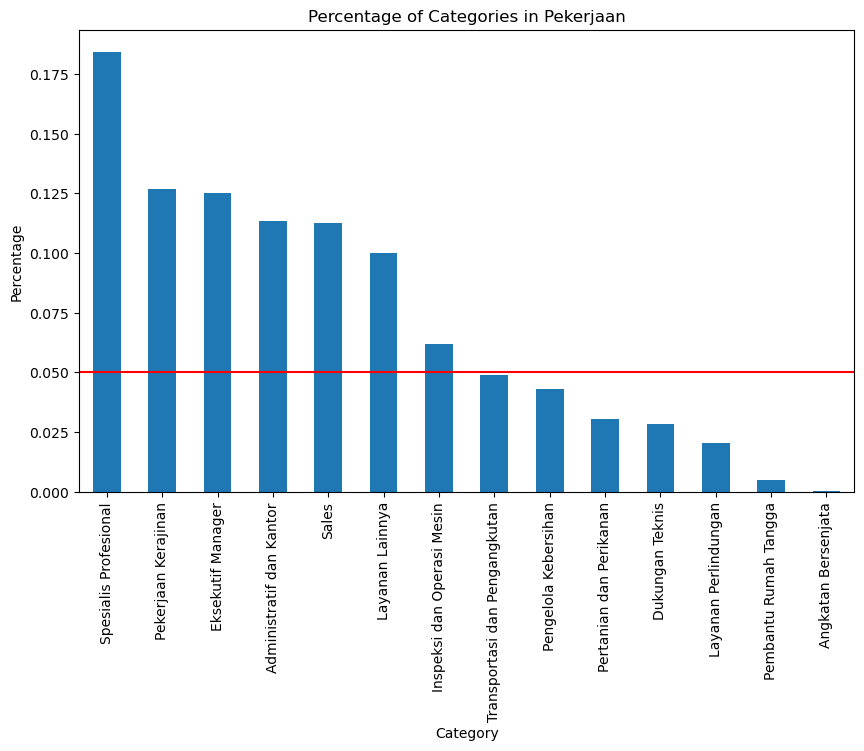

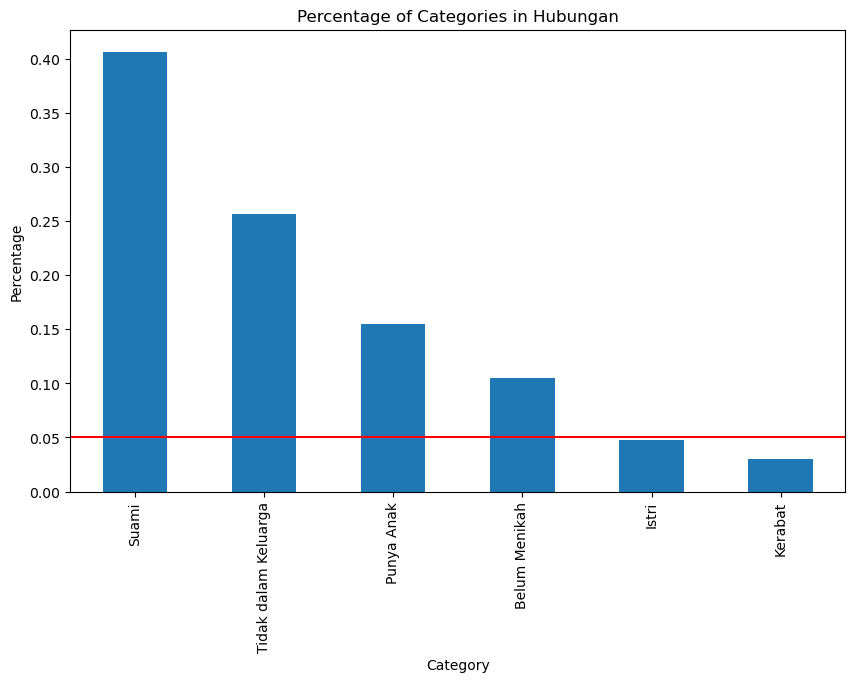

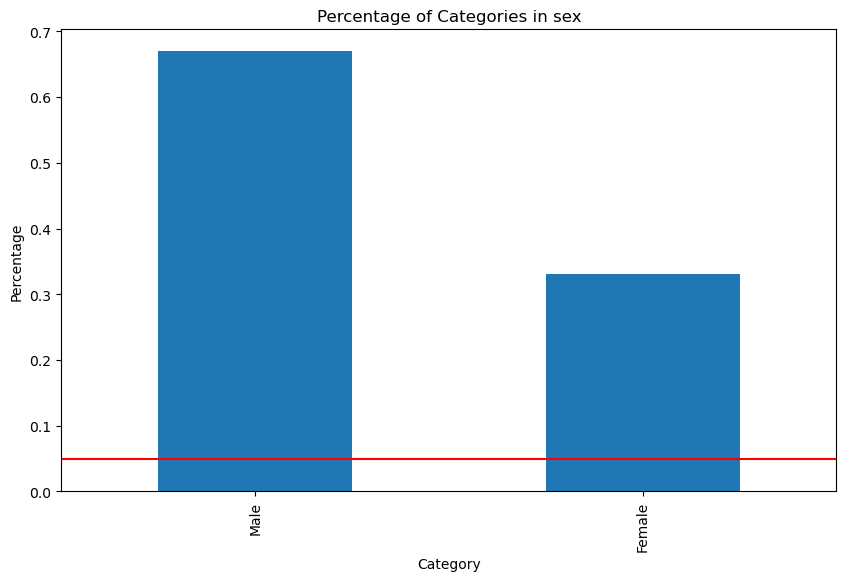

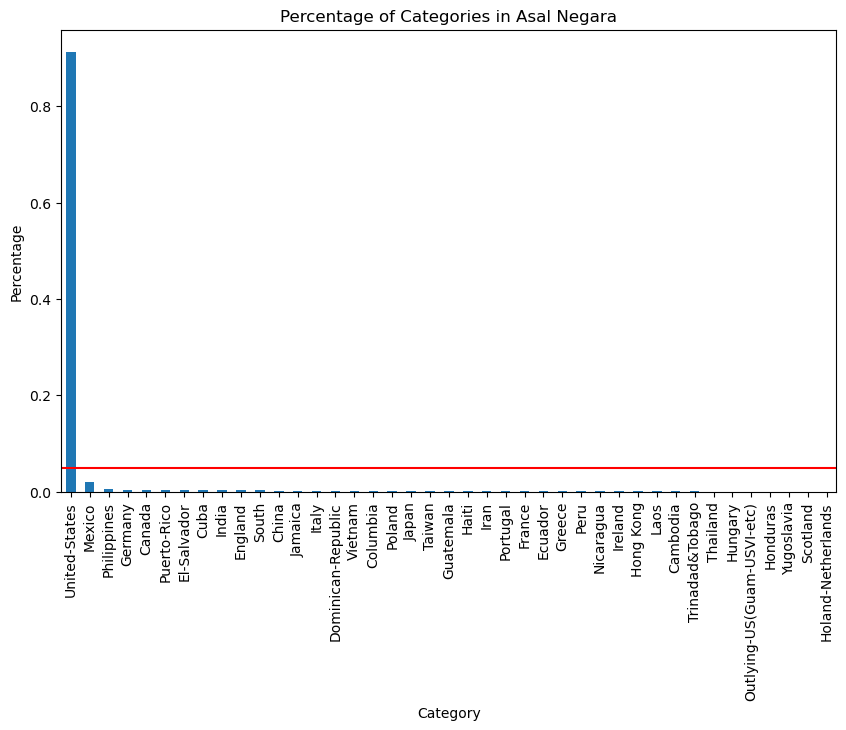

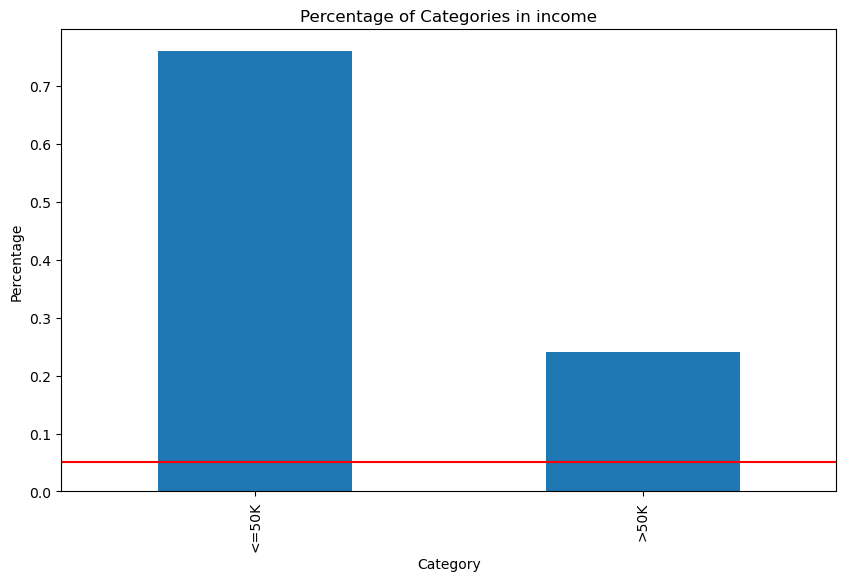

In [345]:
# get the missing column names
cat_cols = [col for col in train.columns if train[col].dtype == 'object']

for col in cat_cols:
    value_counts = train[col].value_counts(normalize=True)  # Normalize to get percentages

    if not value_counts.empty:
        plt.figure(figsize=(10, 6))
        value_counts.plot(kind='bar')
        plt.title(f'Percentage of Categories in {col}')
        plt.axhline(0.05, color='red')
        plt.xlabel('Category')
        plt.ylabel('Percentage')
        plt.show()

Rare label encoding: `Pekerjaan`

In [346]:
rare_encoder = RareLabelEncoder(
    tol = 0.05,
    n_categories = 3,
    variables = 'Pekerjaan'
)

train['Pekerjaan'] = rare_encoder.fit_transform(train[['Pekerjaan']])
test['Pekerjaan'] = rare_encoder.transform(test[['Pekerjaan']])

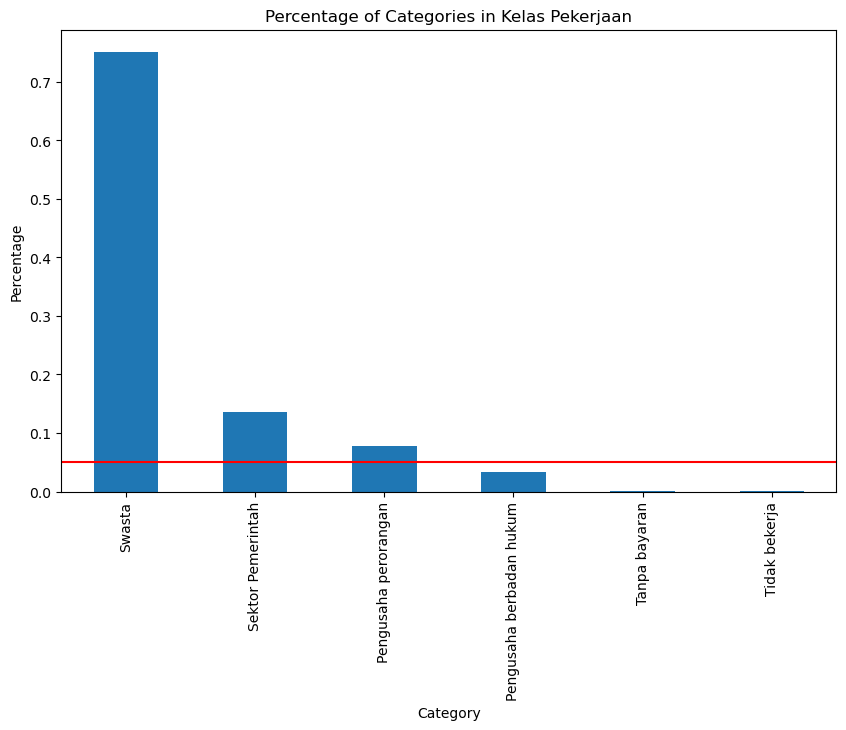

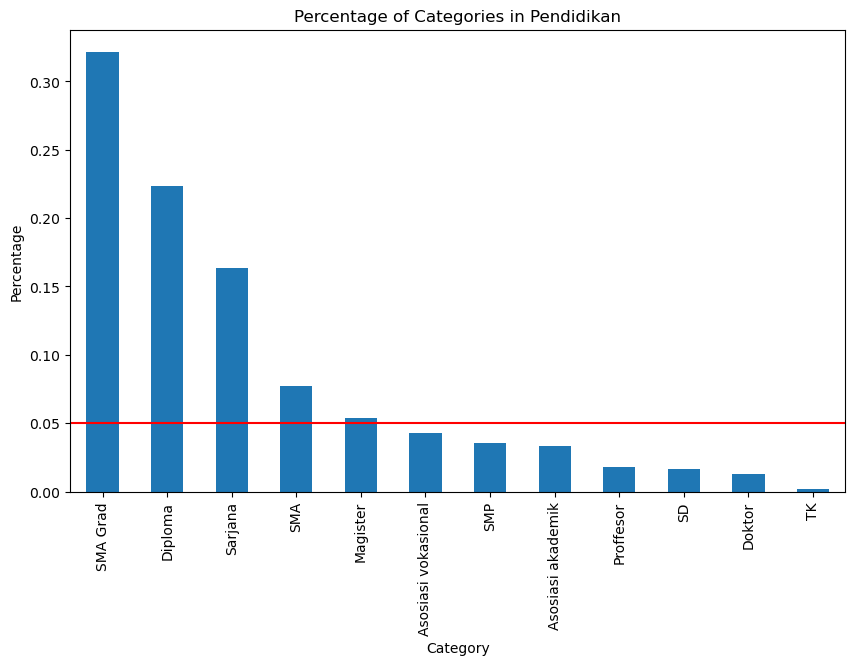

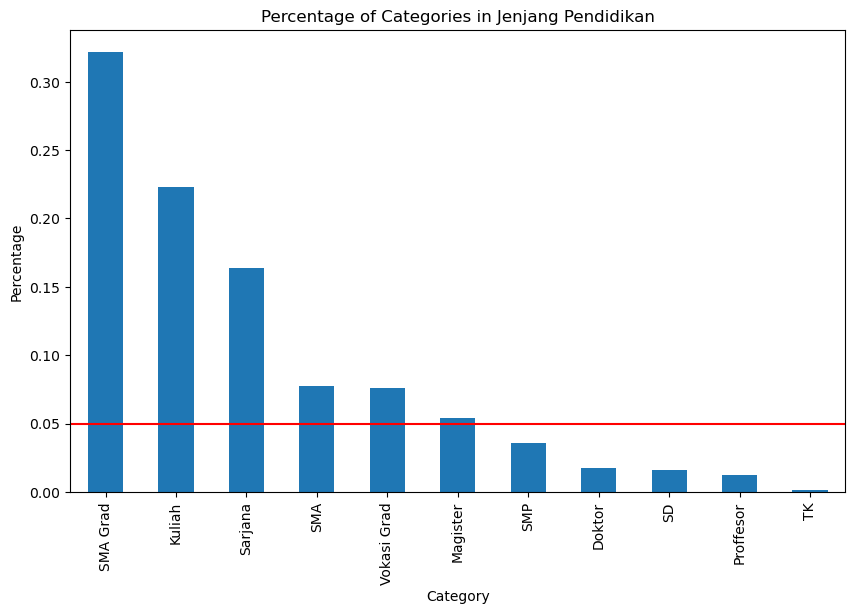

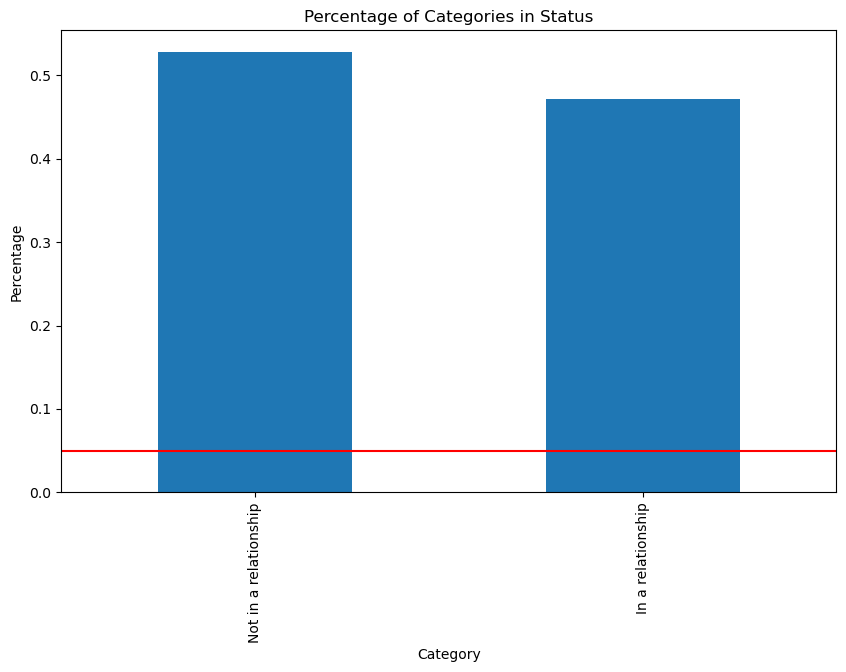

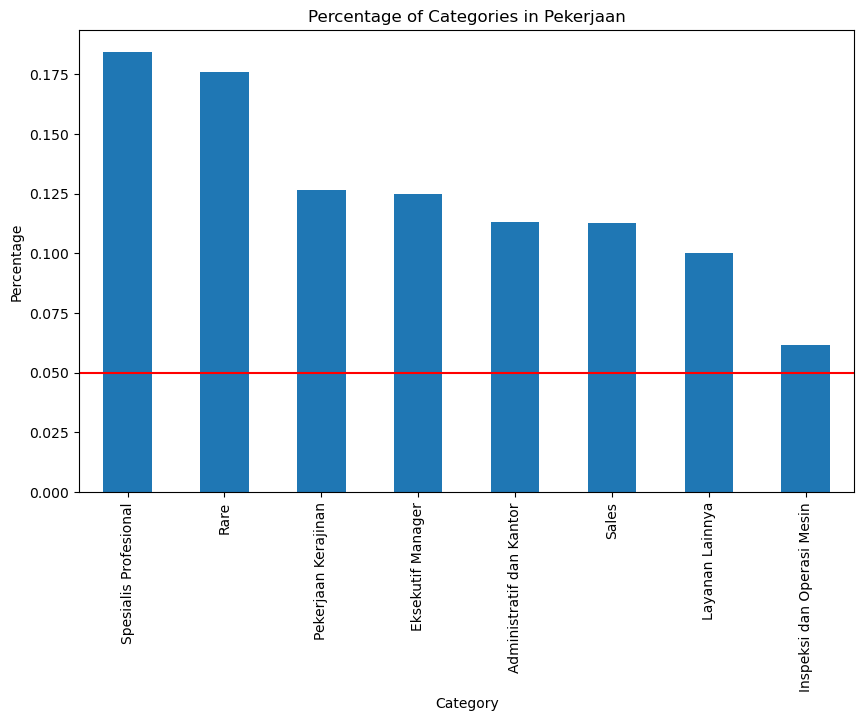

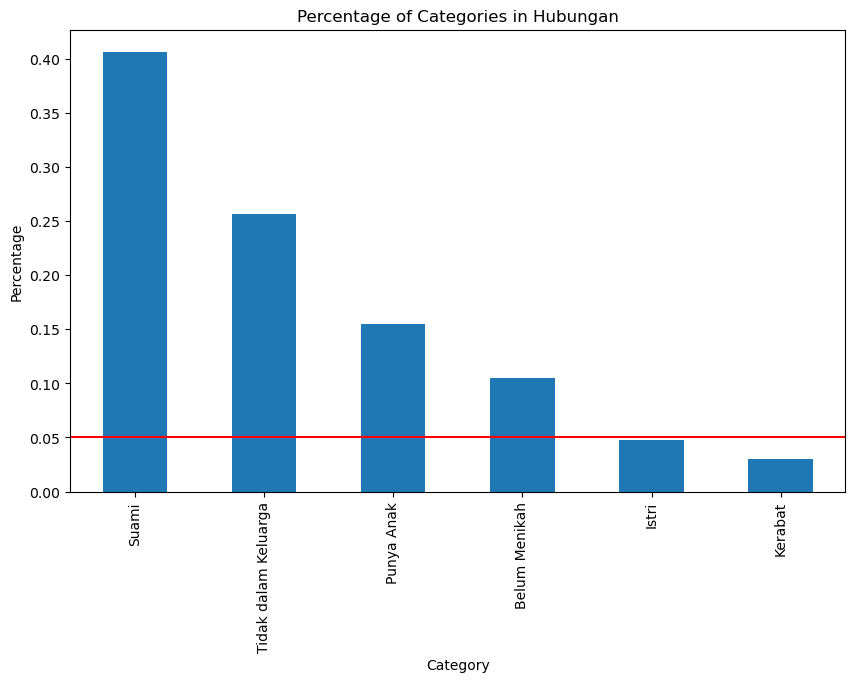

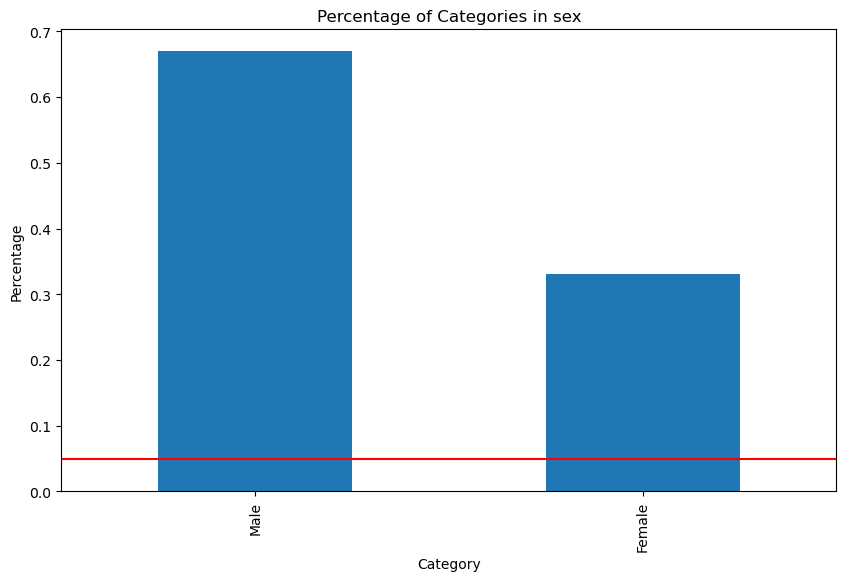

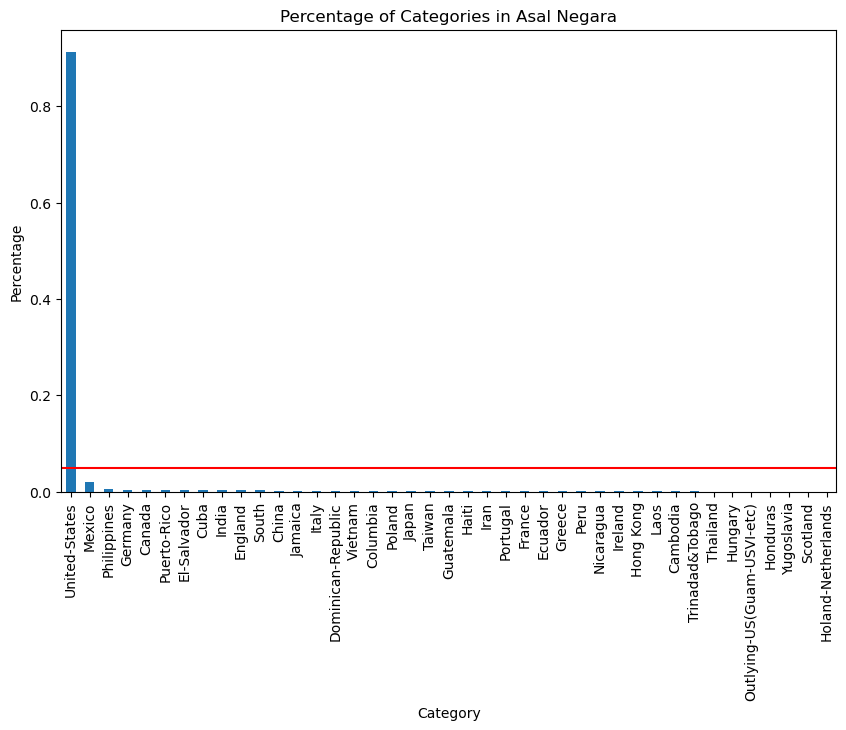

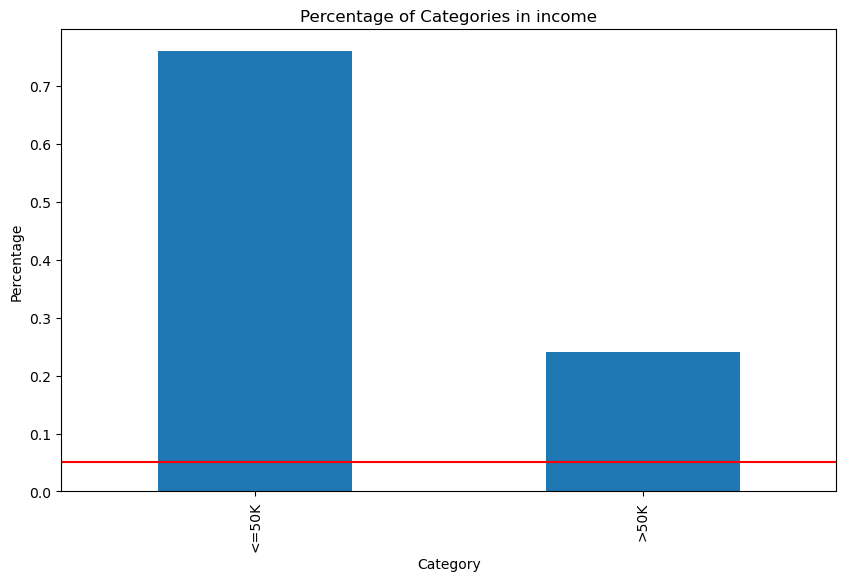

In [347]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']

for col in cat_cols:
    value_counts = train[col].value_counts(normalize=True)  # Normalize to get percentages

    if not value_counts.empty:
        plt.figure(figsize=(10, 6))
        value_counts.plot(kind='bar')
        plt.title(f'Percentage of Categories in {col}')
        plt.axhline(0.05, color='red')
        plt.xlabel('Category')
        plt.ylabel('Percentage')
        plt.show()

Apply label encoding to categorical column

In [348]:
encoder = LabelEncoder()

# Get the list of columns to encode (excluding 'income')
cat_cols = test.select_dtypes('object').columns

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    # Fit and transform on the training set
    train[col] = encoder.fit_transform(train[col])
    
    # Transform on the test set
    test[col] = encoder.transform(test[col])


In [349]:
train.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,3,37210,10,8,0,1,4,1,1,0,0,45,38,2.0,>50K,0
1,1981,3,101950,4,2,1,1,5,1,0,0,0,45,38,0.0,<=50K,0
2,2004,3,122244,8,6,1,7,5,1,0,0,0,28,38,0.0,<=50K,0
3,1984,2,24763,2,1,1,5,0,1,1,6849,0,40,38,0.0,<=50K,0
4,2000,3,113936,10,8,1,7,3,1,1,0,0,40,38,0.0,<=50K,0


In [350]:
test.head()

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,no_income
0,1993,0,117963,3,3,1,7,3,1,1,0,0,40,38,0.0,0
1,2004,3,201490,2,1,1,0,3,1,1,0,0,40,38,0.0,0
2,1946,0,385242,10,8,0,1,4,1,1,9386,0,45,38,2.0,0
3,1992,3,164197,10,8,0,4,4,1,1,0,0,44,38,0.0,0
4,1963,3,92691,8,6,0,0,4,1,1,0,0,3,38,0.0,0


In [351]:
# for target variables
le = LabelEncoder()

train['income'] = le.fit_transform(train['income'])
train.head(5)

,Tahun Kelahiran,Kelas Pekerjaan,fnlwgt,Pendidikan,Jenjang Pendidikan,Status,Pekerjaan,Hubungan,Etnis,sex,pendapatan,pengeluaran,hours per week,Asal Negara,jumlah_anak,income,no_income
0,1992,3,37210,10,8,0,1,4,1,1,0,0,45,38,2.0,1,0
1,1981,3,101950,4,2,1,1,5,1,0,0,0,45,38,0.0,0,0
2,2004,3,122244,8,6,1,7,5,1,0,0,0,28,38,0.0,0,0
3,1984,2,24763,2,1,1,5,0,1,1,6849,0,40,38,0.0,0,0
4,2000,3,113936,10,8,1,7,3,1,1,0,0,40,38,0.0,0,0


In [352]:
check_data(train)

--------------------------------------------------
Missing data: 0
Duplicated data: 37
--------------------------------------------------
--------------------------------------------------


In [353]:
check_data(test)

--------------------------------------------------
Missing data: 0
Duplicated data: 1
--------------------------------------------------
--------------------------------------------------


In [354]:
# train.to_csv('dataset-modified/train-feature-engineered.csv', index=False)
# test.to_csv('dataset-modified/test-feature-engineered.csv', index=False)

In [355]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score,accuracy_score,classification_report

# Pisahkan fitur dan target dari data training
X = train.drop(['income'], axis=1)  # Fitur (semua kolom kecuali target)
y = train['income']  # Target

# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi model LightGBM
model = LGBMClassifier(
    objective='binary',            # Ganti dengan objective sesuai kebutuhan (misalnya 'regression' untuk regresi)
    metric='binary_error',         # Metrik yang digunakan untuk evaluasi model
    n_estimators=129,              # Jumlah estimasi (trees)
    learning_rate=0.1,             # Kecepatan pembelajaran
    num_leaves=31,                # Jumlah daun pada setiap pohon
    # max_depth=-1,                  # Kedalaman maksimum pohon, -1 berarti tidak ada batas
    min_child_samples=20,          # Jumlah minimal sampel di setiap daun
    subsample=0.75,                 # Rasio sampel yang digunakan untuk membangun setiap pohon
    colsample_bytree=0.6,          # Rasio kolom yang digunakan untuk membangun setiap pohon
    random_state=42
)
# 1000 1177
# highest 0.874
# Latih model
model.fit(X_train, y_train)

# Lakukan prediksi pada data test
y_pred = model.predict(X_test)

# Evaluasi model menggunakan F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

# Cetak hasil
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (weighted):", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
Accuracy: 0.8732259301879555
F1 Score (weighted): 0.8683672835718883

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      3937
           1       0.80      0.64      0.71      1277

    accuracy                           0.87      5214
   macro avg       0.85      0.80      0.82      521

In [356]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X = train.drop(['income'], axis=1)  # Fitur (semua kolom kecuali target)
y = train['income']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    model = LGBMClassifier(
        objective='binary',
        metric='binary_error',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return f1  # Optuna will maximize this score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_model = LGBMClassifier(
    objective='binary',
    metric='binary_error',
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    num_leaves=trial.params['num_leaves'],
    min_child_samples=trial.params['min_child_samples'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    random_state=42,
    class_weight='balanced'
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (weighted):", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


[I 2024-09-02 17:07:06,756] A new study created in memory with name: no-name-042cbe27-ee9b-420a-bbc9-43b2642c1cf4


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:07,040] Trial 0 finished with value: 0.8630206456482553 and parameters: {'n_estimators': 108, 'learning_rate': 0.2564836534922562, 'num_leaves': 21, 'min_child_samples': 25, 'subsample': 0.5586525119985568, 'colsample_bytree': 0.920568311369748}. Best is trial 0 with value: 0.8630206456482553.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:07,735] Trial 1 finished with value: 0.8650323221811418 and parameters: {'n_estimators': 107, 'learning_rate': 0.07732370697870929, 'num_leaves': 103, 'min_child_samples': 37, 'subsample': 0.9296517490857903, 'colsample_bytree': 0.8941232501744069}. Best is trial 1 with value: 0.8650323221811418.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:08,495] Trial 2 finished with value: 0.868811072122983 and parameters: {'n_estimators': 139, 'learning_rate': 0.03388319649997048, 'num_leaves': 140, 'min_child_samples': 11, 'subsample': 0.5630963118540802, 'colsample_bytree': 0.6988503314009678}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:08,921] Trial 3 finished with value: 0.8662274991991613 and parameters: {'n_estimators': 116, 'learning_rate': 0.16906350190809688, 'num_leaves': 57, 'min_child_samples': 21, 'subsample': 0.5384378910828913, 'colsample_bytree': 0.7259572871713731}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:09,359] Trial 4 finished with value: 0.8641659323316333 and parameters: {'n_estimators': 114, 'learning_rate': 0.268303286260556, 'num_leaves': 40, 'min_child_samples': 100, 'subsample': 0.7877915433619137, 'colsample_bytree': 0.737013132414893}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:09,877] Trial 5 finished with value: 0.8686438021815266 and parameters: {'n_estimators': 152, 'learning_rate': 0.10723328859880127, 'num_leaves': 52, 'min_child_samples': 50, 'subsample': 0.728861964407622, 'colsample_bytree': 0.5573056658809681}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:10,222] Trial 6 finished with value: 0.865077745967918 and parameters: {'n_estimators': 56, 'learning_rate': 0.15764223870857447, 'num_leaves': 92, 'min_child_samples': 70, 'subsample': 0.8414686590247746, 'colsample_bytree': 0.6049290369030347}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:10,508] Trial 7 finished with value: 0.8654677262570168 and parameters: {'n_estimators': 60, 'learning_rate': 0.10133624412128699, 'num_leaves': 110, 'min_child_samples': 90, 'subsample': 0.9249916313337841, 'colsample_bytree': 0.8088220341399481}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:10,802] Trial 8 finished with value: 0.8643308287110721 and parameters: {'n_estimators': 61, 'learning_rate': 0.14557924453467969, 'num_leaves': 132, 'min_child_samples': 94, 'subsample': 0.6491513286621227, 'colsample_bytree': 0.6866502157766626}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:11,277] Trial 9 finished with value: 0.866482506514423 and parameters: {'n_estimators': 86, 'learning_rate': 0.08281442097620456, 'num_leaves': 83, 'min_child_samples': 11, 'subsample': 0.8712532773422649, 'colsample_bytree': 0.7770453853161428}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-02 17:07:12,575] Trial 10 finished with value: 0.8597479393990684 and parameters: {'n_estimators': 190, 'learning_rate': 0.010714453781162682, 'num_leaves': 148, 'min_child_samples': 64, 'subsample': 0.6448281226201863, 'colsample_bytree': 0.6317881454907271}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:13,259] Trial 11 finished with value: 0.8523080215887461 and parameters: {'n_estimators': 159, 'learning_rate': 0.011073493488189957, 'num_leaves': 65, 'min_child_samples': 46, 'subsample': 0.6976130644936451, 'colsample_bytree': 0.5019208418928542}. Best is trial 2 with value: 0.868811072122983.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:13,918] Trial 12 finished with value: 0.8702270503443705 and parameters: {'n_estimators': 156, 'learning_rate': 0.043842263718581354, 'num_leaves': 64, 'min_child_samples': 51, 'subsample': 0.5015322088450626, 'colsample_bytree': 0.5153850975703936}. Best is trial 12 with value: 0.8702270503443705.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:14,903] Trial 13 finished with value: 0.8661402647105341 and parameters: {'n_estimators': 148, 'learning_rate': 0.04501759883770203, 'num_leaves': 126, 'min_child_samples': 79, 'subsample': 0.5011240361246363, 'colsample_bytree': 0.9927335838261548}. Best is trial 12 with value: 0.8702270503443705.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:15,672] Trial 14 finished with value: 0.8597097638980321 and parameters: {'n_estimators': 179, 'learning_rate': 0.20825567522322852, 'num_leaves': 75, 'min_child_samples': 33, 'subsample': 0.5927088303902501, 'colsample_bytree': 0.5054094833884832}. Best is trial 12 with value: 0.8702270503443705.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:16,036] Trial 15 finished with value: 0.8704401639566207 and parameters: {'n_estimators': 138, 'learning_rate': 0.04496353396701122, 'num_leaves': 36, 'min_child_samples': 12, 'subsample': 0.603430537259433, 'colsample_bytree': 0.6428101390827172}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:16,465] Trial 16 finished with value: 0.8696974859396974 and parameters: {'n_estimators': 174, 'learning_rate': 0.056932675395763147, 'num_leaves': 30, 'min_child_samples': 59, 'subsample': 0.612899322103753, 'colsample_bytree': 0.6120832941252509}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:16,838] Trial 17 finished with value: 0.8687315002679128 and parameters: {'n_estimators': 129, 'learning_rate': 0.12757341627392305, 'num_leaves': 44, 'min_child_samples': 41, 'subsample': 0.5165295838245203, 'colsample_bytree': 0.5596135921881837}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:17,649] Trial 18 finished with value: 0.8587939429172787 and parameters: {'n_estimators': 169, 'learning_rate': 0.20409880076329606, 'num_leaves': 69, 'min_child_samples': 26, 'subsample': 0.6744192014559525, 'colsample_bytree': 0.6572466657035061}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:17,967] Trial 19 finished with value: 0.8692092175793623 and parameters: {'n_estimators': 89, 'learning_rate': 0.06189999226605955, 'num_leaves': 34, 'min_child_samples': 70, 'subsample': 0.7675649673464725, 'colsample_bytree': 0.5675962816127555}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:18,524] Trial 20 finished with value: 0.855101093864376 and parameters: {'n_estimators': 194, 'learning_rate': 0.2960758585854192, 'num_leaves': 54, 'min_child_samples': 53, 'subsample': 0.6011686789078914, 'colsample_bytree': 0.8252000371923622}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:18,931] Trial 21 finished with value: 0.8689353271096084 and parameters: {'n_estimators': 169, 'learning_rate': 0.053738678533127665, 'num_leaves': 20, 'min_child_samples': 61, 'subsample': 0.6176228663871719, 'colsample_bytree': 0.6157117064311}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:19,291] Trial 22 finished with value: 0.8651508355509638 and parameters: {'n_estimators': 134, 'learning_rate': 0.032668811736633295, 'num_leaves': 31, 'min_child_samples': 81, 'subsample': 0.5795128328356377, 'colsample_bytree': 0.5718533923084871}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:19,840] Trial 23 finished with value: 0.8669192201710734 and parameters: {'n_estimators': 166, 'learning_rate': 0.08321791723842477, 'num_leaves': 46, 'min_child_samples': 58, 'subsample': 0.9900133196430566, 'colsample_bytree': 0.6605527320797488}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:20,362] Trial 24 finished with value: 0.8690393795422288 and parameters: {'n_estimators': 183, 'learning_rate': 0.11344038055708132, 'num_leaves': 31, 'min_child_samples': 45, 'subsample': 0.503000773574829, 'colsample_bytree': 0.5283034523579236}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:21,190] Trial 25 finished with value: 0.8691280818381004 and parameters: {'n_estimators': 145, 'learning_rate': 0.06386726054254988, 'num_leaves': 62, 'min_child_samples': 69, 'subsample': 0.708629001349924, 'colsample_bytree': 0.5943239058894906}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:21,866] Trial 26 finished with value: 0.8681559962690081 and parameters: {'n_estimators': 200, 'learning_rate': 0.029331749126614032, 'num_leaves': 78, 'min_child_samples': 80, 'subsample': 0.6314856936241149, 'colsample_bytree': 0.6443323515843277}. Best is trial 15 with value: 0.8704401639566207.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:22,208] Trial 27 finished with value: 0.8722141824624172 and parameters: {'n_estimators': 157, 'learning_rate': 0.09077765965155946, 'num_leaves': 37, 'min_child_samples': 19, 'subsample': 0.5485753297639192, 'colsample_bytree': 0.5288166104827438}. Best is trial 27 with value: 0.8722141824624172.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:22,737] Trial 28 finished with value: 0.8693925114792547 and parameters: {'n_estimators': 158, 'learning_rate': 0.09054677003363099, 'num_leaves': 91, 'min_child_samples': 18, 'subsample': 0.538089129530875, 'colsample_bytree': 0.5341889327563851}. Best is trial 27 with value: 0.8722141824624172.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:23,038] Trial 29 finished with value: 0.8643818039723288 and parameters: {'n_estimators': 126, 'learning_rate': 0.1989919809671627, 'num_leaves': 48, 'min_child_samples': 29, 'subsample': 0.5689955417421239, 'colsample_bytree': 0.5331191059585427}. Best is trial 27 with value: 0.8722141824624172.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:23,384] Trial 30 finished with value: 0.8715542778110572 and parameters: {'n_estimators': 100, 'learning_rate': 0.1227015780215521, 'num_leaves': 39, 'min_child_samples': 18, 'subsample': 0.5365683470404926, 'colsample_bytree': 0.588157775613213}. Best is trial 27 with value: 0.8722141824624172.
[I 2024-09-02 17:07:23,621] Trial 31 finished with value: 0.8689081267331278 and parameters: {'n_estimators': 92, 'learning_rate': 0.11019477470917524, 'num_leaves': 40, 'min_child_samples': 17, 'subsample': 0.5428702133804895, 'colsample_bytree': 0.5848142737498863}. Best is trial 27 with value: 0.8722141824624172.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:23,839] Trial 32 finished with value: 0.8695956534370465 and parameters: {'n_estimators': 105, 'learning_rate': 0.1302779319201861, 'num_leaves': 22, 'min_child_samples': 22, 'subsample': 0.5374605433748179, 'colsample_bytree': 0.5384986084568673}. Best is trial 27 with value: 0.8722141824624172.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:24,128] Trial 33 finished with value: 0.872438534035959 and parameters: {'n_estimators': 140, 'learning_rate': 0.06909713248136007, 'num_leaves': 38, 'min_child_samples': 11, 'subsample': 0.5751172149063746, 'colsample_bytree': 0.6807891143702667}. Best is trial 33 with value: 0.872438534035959.
[I 2024-09-02 17:07:24,375] Trial 34 finished with value: 0.8696933268361777 and parameters: {'n_estimators': 139, 'learning_rate': 0.07222496418187968, 'num_leaves': 26, 'min_child_samples': 10, 'subsample': 0.5752482206116376, 'colsample_bytree': 0.6979748476082044}. Best is trial 33 with value: 0.872438534035959.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:24,626] Trial 35 finished with value: 0.8645570315580674 and parameters: {'n_estimators': 118, 'learning_rate': 0.1789579677534571, 'num_leaves': 39, 'min_child_samples': 17, 'subsample': 0.5429035796705323, 'colsample_bytree': 0.6835628520998288}. Best is trial 33 with value: 0.872438534035959.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:24,893] Trial 36 finished with value: 0.8678958580296133 and parameters: {'n_estimators': 106, 'learning_rate': 0.13023384437992014, 'num_leaves': 55, 'min_child_samples': 35, 'subsample': 0.6809068846340206, 'colsample_bytree': 0.7207084147353121}. Best is trial 33 with value: 0.872438534035959.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:25,146] Trial 37 finished with value: 0.8708465032594964 and parameters: {'n_estimators': 75, 'learning_rate': 0.09405069044324912, 'num_leaves': 37, 'min_child_samples': 14, 'subsample': 0.6583080608763867, 'colsample_bytree': 0.7538582225318502}. Best is trial 33 with value: 0.872438534035959.
[I 2024-09-02 17:07:25,378] Trial 38 finished with value: 0.8686870697585183 and parameters: {'n_estimators': 73, 'learning_rate': 0.14727802118481143, 'num_leaves': 48, 'min_child_samples': 29, 'subsample': 0.6533648928173263, 'colsample_bytree': 0.7648058226338326}. Best is trial 33 with value: 0.872438534035959.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:25,688] Trial 39 finished with value: 0.8645515992227484 and parameters: {'n_estimators': 74, 'learning_rate': 0.10113153114944222, 'num_leaves': 102, 'min_child_samples': 22, 'subsample': 0.7382650648524021, 'colsample_bytree': 0.8554846034969038}. Best is trial 33 with value: 0.872438534035959.
[I 2024-09-02 17:07:25,887] Trial 40 finished with value: 0.8701820843131465 and parameters: {'n_estimators': 98, 'learning_rate': 0.08988154139058262, 'num_leaves': 25, 'min_child_samples': 15, 'subsample': 0.5537275132586685, 'colsample_bytree': 0.8025506389009094}. Best is trial 33 with value: 0.872438534035959.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:26,180] Trial 41 finished with value: 0.8734757354843884 and parameters: {'n_estimators': 139, 'learning_rate': 0.11997582961826758, 'num_leaves': 40, 'min_child_samples': 13, 'subsample': 0.5926746285422869, 'colsample_bytree': 0.740799613842756}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:26,476] Trial 42 finished with value: 0.8653436951337264 and parameters: {'n_estimators': 122, 'learning_rate': 0.11864723653651657, 'num_leaves': 57, 'min_child_samples': 24, 'subsample': 0.5775372653485721, 'colsample_bytree': 0.7411068383313913}. Best is trial 41 with value: 0.8734757354843884.
[I 2024-09-02 17:07:26,686] Trial 43 finished with value: 0.868110988348646 and parameters: {'n_estimators': 78, 'learning_rate': 0.16462771823506614, 'num_leaves': 43, 'min_child_samples': 14, 'subsample': 0.628280632186856, 'colsample_bytree': 0.7175326649901231}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:26,910] Trial 44 finished with value: 0.8659152861859791 and parameters: {'n_estimators': 114, 'learning_rate': 0.1413770446115905, 'num_leaves': 36, 'min_child_samples': 19, 'subsample': 0.5240480497841831, 'colsample_bytree': 0.7672058961818222}. Best is trial 41 with value: 0.8734757354843884.
[I 2024-09-02 17:07:27,123] Trial 45 finished with value: 0.8700055084921213 and parameters: {'n_estimators': 66, 'learning_rate': 0.09491051415022121, 'num_leaves': 51, 'min_child_samples': 29, 'subsample': 0.5622616851003736, 'colsample_bytree': 0.7866293035335953}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] N

[I 2024-09-02 17:07:27,387] Trial 46 finished with value: 0.8699152155599552 and parameters: {'n_estimators': 148, 'learning_rate': 0.0741984440650903, 'num_leaves': 26, 'min_child_samples': 14, 'subsample': 0.6460025224194431, 'colsample_bytree': 0.8555422558303977}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:27,713] Trial 47 finished with value: 0.8671036292921597 and parameters: {'n_estimators': 132, 'learning_rate': 0.12085254845422912, 'num_leaves': 60, 'min_child_samples': 10, 'subsample': 0.8363388401266744, 'colsample_bytree': 0.7058905809293766}. Best is trial 41 with value: 0.8734757354843884.
[I 2024-09-02 17:07:27,881] Trial 48 finished with value: 0.8683672835718883 and parameters: {'n_estimators': 54, 'learning_rate': 0.1774753637546619, 'num_leaves': 39, 'min_child_samples': 39, 'subsample': 0.5899295522876281, 'colsample_bytree': 0.6832279241586812}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:28,477] Trial 49 finished with value: 0.8650379549671778 and parameters: {'n_estimators': 141, 'learning_rate': 0.10444294574092886, 'num_leaves': 70, 'min_child_samples': 25, 'subsample': 0.5580941287322049, 'colsample_bytree': 0.7439235940126568}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:28,866] Trial 50 finished with value: 0.8685997497886886 and parameters: {'n_estimators': 97, 'learning_rate': 0.1365357496602964, 'num_leaves': 30, 'min_child_samples': 20, 'subsample': 0.6648363660805958, 'colsample_bytree': 0.9544220315015985}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:29,220] Trial 51 finished with value: 0.8694569978155013 and parameters: {'n_estimators': 152, 'learning_rate': 0.042971418368292304, 'num_leaves': 35, 'min_child_samples': 13, 'subsample': 0.6022265002140359, 'colsample_bytree': 0.63376743151768}. Best is trial 41 with value: 0.8734757354843884.
[I 2024-09-02 17:07:29,456] Trial 52 finished with value: 0.8580497959823049 and parameters: {'n_estimators': 83, 'learning_rate': 0.022379326978068773, 'num_leaves': 43, 'min_child_samples': 12, 'subsample': 0.6095628471241914, 'colsample_bytree': 0.6647135358835567}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] N

[I 2024-09-02 17:07:30,046] Trial 53 finished with value: 0.8681559962690081 and parameters: {'n_estimators': 163, 'learning_rate': 0.08158427848085648, 'num_leaves': 51, 'min_child_samples': 17, 'subsample': 0.5217329313342154, 'colsample_bytree': 0.6145557169062785}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:30,460] Trial 54 finished with value: 0.8704484955653808 and parameters: {'n_estimators': 135, 'learning_rate': 0.0695946725888813, 'num_leaves': 37, 'min_child_samples': 10, 'subsample': 0.6307026950991654, 'colsample_bytree': 0.5853268801977823}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:31,193] Trial 55 finished with value: 0.8680717722118015 and parameters: {'n_estimators': 112, 'learning_rate': 0.06945617926156616, 'num_leaves': 117, 'min_child_samples': 32, 'subsample': 0.6996140620921657, 'colsample_bytree': 0.5525422526563557}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:31,587] Trial 56 finished with value: 0.8672255814997427 and parameters: {'n_estimators': 123, 'learning_rate': 0.15560495403958646, 'num_leaves': 27, 'min_child_samples': 21, 'subsample': 0.6317683751913722, 'colsample_bytree': 0.5842912395332893}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:31,918] Trial 57 finished with value: 0.8690837855598521 and parameters: {'n_estimators': 135, 'learning_rate': 0.09494770345515238, 'num_leaves': 43, 'min_child_samples': 10, 'subsample': 0.5886234151930612, 'colsample_bytree': 0.7553836182923911}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:32,358] Trial 58 finished with value: 0.8719949529694302 and parameters: {'n_estimators': 143, 'learning_rate': 0.0515194625132161, 'num_leaves': 33, 'min_child_samples': 26, 'subsample': 0.7144492799755016, 'colsample_bytree': 0.5139886834833137}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:32,721] Trial 59 finished with value: 0.8719875370260329 and parameters: {'n_estimators': 151, 'learning_rate': 0.04946605098863946, 'num_leaves': 21, 'min_child_samples': 26, 'subsample': 0.7600547504554225, 'colsample_bytree': 0.5004219420834505}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:33,133] Trial 60 finished with value: 0.8722593293421669 and parameters: {'n_estimators': 152, 'learning_rate': 0.048881856670010035, 'num_leaves': 31, 'min_child_samples': 27, 'subsample': 0.8037828658647092, 'colsample_bytree': 0.5132649449220011}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:33,694] Trial 61 finished with value: 0.8711335891277017 and parameters: {'n_estimators': 152, 'learning_rate': 0.04862182742809736, 'num_leaves': 21, 'min_child_samples': 27, 'subsample': 0.8117734720729767, 'colsample_bytree': 0.5004221406861188}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:34,132] Trial 62 finished with value: 0.8640132788255296 and parameters: {'n_estimators': 145, 'learning_rate': 0.020724800636394276, 'num_leaves': 33, 'min_child_samples': 32, 'subsample': 0.7730745034072716, 'colsample_bytree': 0.5229593559729}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:34,598] Trial 63 finished with value: 0.8701777761338058 and parameters: {'n_estimators': 155, 'learning_rate': 0.05567604557336264, 'num_leaves': 29, 'min_child_samples': 23, 'subsample': 0.8030432884666595, 'colsample_bytree': 0.5472458425944982}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:34,984] Trial 64 finished with value: 0.8710655838512096 and parameters: {'n_estimators': 161, 'learning_rate': 0.061572966117885854, 'num_leaves': 20, 'min_child_samples': 43, 'subsample': 0.8458384455950414, 'colsample_bytree': 0.5148835006205627}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:35,428] Trial 65 finished with value: 0.8682325783169769 and parameters: {'n_estimators': 143, 'learning_rate': 0.041457483142574955, 'num_leaves': 24, 'min_child_samples': 38, 'subsample': 0.903727059652614, 'colsample_bytree': 0.5141259264222608}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:35,863] Trial 66 finished with value: 0.8692803012617631 and parameters: {'n_estimators': 177, 'learning_rate': 0.03839032737560578, 'num_leaves': 32, 'min_child_samples': 27, 'subsample': 0.7244302645497296, 'colsample_bytree': 0.5688450330786505}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:36,234] Trial 67 finished with value: 0.8722603442759792 and parameters: {'n_estimators': 148, 'learning_rate': 0.08311123054371941, 'num_leaves': 46, 'min_child_samples': 35, 'subsample': 0.7698794225653267, 'colsample_bytree': 0.5540480251471187}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:36,701] Trial 68 finished with value: 0.8707152297462393 and parameters: {'n_estimators': 149, 'learning_rate': 0.08198243528221122, 'num_leaves': 47, 'min_child_samples': 33, 'subsample': 0.7584881914748942, 'colsample_bytree': 0.5492945322201734}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:37,128] Trial 69 finished with value: 0.861971467132476 and parameters: {'n_estimators': 171, 'learning_rate': 0.23607102370128552, 'num_leaves': 42, 'min_child_samples': 48, 'subsample': 0.7951991922208681, 'colsample_bytree': 0.5227324203440648}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:37,459] Trial 70 finished with value: 0.8700465175696462 and parameters: {'n_estimators': 157, 'learning_rate': 0.05315470363857475, 'num_leaves': 28, 'min_child_samples': 36, 'subsample': 0.8173927436496042, 'colsample_bytree': 0.5041065295943575}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:37,833] Trial 71 finished with value: 0.867944111298824 and parameters: {'n_estimators': 129, 'learning_rate': 0.03169046445083504, 'num_leaves': 33, 'min_child_samples': 19, 'subsample': 0.7799570962664548, 'colsample_bytree': 0.5546149243400661}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:38,203] Trial 72 finished with value: 0.8712889670274568 and parameters: {'n_estimators': 140, 'learning_rate': 0.06306758334936857, 'num_leaves': 49, 'min_child_samples': 16, 'subsample': 0.7500907292339484, 'colsample_bytree': 0.5408192933386415}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:38,553] Trial 73 finished with value: 0.8692599878053562 and parameters: {'n_estimators': 166, 'learning_rate': 0.10923934916946114, 'num_leaves': 39, 'min_child_samples': 24, 'subsample': 0.7237809710505632, 'colsample_bytree': 0.6007323199794773}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:38,858] Trial 74 finished with value: 0.8717310465326393 and parameters: {'n_estimators': 146, 'learning_rate': 0.08653907275212684, 'num_leaves': 24, 'min_child_samples': 30, 'subsample': 0.8277036149246206, 'colsample_bytree': 0.567696417865274}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:39,142] Trial 75 finished with value: 0.8704036539485006 and parameters: {'n_estimators': 153, 'learning_rate': 0.07714996623976418, 'num_leaves': 23, 'min_child_samples': 29, 'subsample': 0.8694576779990641, 'colsample_bytree': 0.5679945080027857}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:39,897] Trial 76 finished with value: 0.8634927561995527 and parameters: {'n_estimators': 147, 'learning_rate': 0.0869180586164613, 'num_leaves': 146, 'min_child_samples': 34, 'subsample': 0.8283423791839056, 'colsample_bytree': 0.5295350583648425}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:40,181] Trial 77 finished with value: 0.8700953562116371 and parameters: {'n_estimators': 138, 'learning_rate': 0.10001728548041573, 'num_leaves': 28, 'min_child_samples': 31, 'subsample': 0.8577225563075955, 'colsample_bytree': 0.5085081940965511}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:40,558] Trial 78 finished with value: 0.8661428262309623 and parameters: {'n_estimators': 163, 'learning_rate': 0.022568661812866632, 'num_leaves': 34, 'min_child_samples': 40, 'subsample': 0.7826434864649556, 'colsample_bytree': 0.5368278916267752}. Best is trial 41 with value: 0.8734757354843884.
[I 2024-09-02 17:07:40,817] Trial 79 finished with value: 0.8697071834693393 and parameters: {'n_estimators': 129, 'learning_rate': 0.05118822965363781, 'num_leaves': 20, 'min_child_samples': 21, 'subsample': 0.764770773491977, 'colsample_bytree': 0.5204559167664683}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:41,176] Trial 80 finished with value: 0.8703166496686423 and parameters: {'n_estimators': 143, 'learning_rate': 0.07435013372118174, 'num_leaves': 45, 'min_child_samples': 26, 'subsample': 0.792111764106141, 'colsample_bytree': 0.5625991709074082}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:41,567] Trial 81 finished with value: 0.8699200363781737 and parameters: {'n_estimators': 149, 'learning_rate': 0.11828483569146188, 'num_leaves': 39, 'min_child_samples': 19, 'subsample': 0.7378287387611755, 'colsample_bytree': 0.5794596560002687}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:41,888] Trial 82 finished with value: 0.8702176584224662 and parameters: {'n_estimators': 159, 'learning_rate': 0.06201160178165952, 'num_leaves': 24, 'min_child_samples': 23, 'subsample': 0.9003154341101461, 'colsample_bytree': 0.5973819865790525}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:42,186] Trial 83 finished with value: 0.8679829256217991 and parameters: {'n_estimators': 137, 'learning_rate': 0.12677255564221487, 'num_leaves': 30, 'min_child_samples': 28, 'subsample': 0.5336897141568406, 'colsample_bytree': 0.6240100780581527}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:42,571] Trial 84 finished with value: 0.8723501191672927 and parameters: {'n_estimators': 132, 'learning_rate': 0.06646872241165215, 'num_leaves': 55, 'min_child_samples': 16, 'subsample': 0.5115074002253499, 'colsample_bytree': 0.54281456162266}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:42,934] Trial 85 finished with value: 0.8712450046666732 and parameters: {'n_estimators': 132, 'learning_rate': 0.08166310191391898, 'num_leaves': 58, 'min_child_samples': 13, 'subsample': 0.5037917977871597, 'colsample_bytree': 0.5414017583437067}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:43,402] Trial 86 finished with value: 0.8712001830455063 and parameters: {'n_estimators': 126, 'learning_rate': 0.06803995163978263, 'num_leaves': 54, 'min_child_samples': 16, 'subsample': 0.9804762510162605, 'colsample_bytree': 0.5578485749162789}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:43,862] Trial 87 finished with value: 0.8688892826783382 and parameters: {'n_estimators': 143, 'learning_rate': 0.03697755657033456, 'num_leaves': 65, 'min_child_samples': 98, 'subsample': 0.551443204570564, 'colsample_bytree': 0.5133118102758284}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:44,220] Trial 88 finished with value: 0.8692423842705492 and parameters: {'n_estimators': 118, 'learning_rate': 0.04837037411162312, 'num_leaves': 46, 'min_child_samples': 25, 'subsample': 0.8227605546366707, 'colsample_bytree': 0.5289785701248486}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:44,569] Trial 89 finished with value: 0.871598090317639 and parameters: {'n_estimators': 155, 'learning_rate': 0.05663488125335825, 'num_leaves': 36, 'min_child_samples': 31, 'subsample': 0.7080842613769049, 'colsample_bytree': 0.5450099705629313}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:45,183] Trial 90 finished with value: 0.8683349186977253 and parameters: {'n_estimators': 149, 'learning_rate': 0.09884536684998477, 'num_leaves': 84, 'min_child_samples': 36, 'subsample': 0.5136716896450311, 'colsample_bytree': 0.5003842171408731}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:45,506] Trial 91 finished with value: 0.868811072122983 and parameters: {'n_estimators': 153, 'learning_rate': 0.05802721812290954, 'num_leaves': 36, 'min_child_samples': 30, 'subsample': 0.7105275703922204, 'colsample_bytree': 0.5724825200610901}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:45,864] Trial 92 finished with value: 0.8708032652736896 and parameters: {'n_estimators': 158, 'learning_rate': 0.08798743380449245, 'num_leaves': 42, 'min_child_samples': 21, 'subsample': 0.6885221773093217, 'colsample_bytree': 0.546579786032995}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:46,172] Trial 93 finished with value: 0.8725703394957892 and parameters: {'n_estimators': 146, 'learning_rate': 0.06714017230844796, 'num_leaves': 32, 'min_child_samples': 26, 'subsample': 0.7504219076562408, 'colsample_bytree': 0.5308169156360157}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:46,535] Trial 94 finished with value: 0.8723937225863478 and parameters: {'n_estimators': 132, 'learning_rate': 0.06684412057504617, 'num_leaves': 31, 'min_child_samples': 26, 'subsample': 0.7499122210068189, 'colsample_bytree': 0.5264061898666424}. Best is trial 41 with value: 0.8734757354843884.
[I 2024-09-02 17:07:46,818] Trial 95 finished with value: 0.8708917807629817 and parameters: {'n_estimators': 132, 'learning_rate': 0.0672692910183097, 'num_leaves': 32, 'min_child_samples': 84, 'subsample': 0.7493651794959199, 'colsample_bytree': 0.5255866636822069}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:47,247] Trial 96 finished with value: 0.8672373370702181 and parameters: {'n_estimators': 141, 'learning_rate': 0.027111319050235016, 'num_leaves': 50, 'min_child_samples': 15, 'subsample': 0.735916470021307, 'colsample_bytree': 0.5147343531462768}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521


[I 2024-09-02 17:07:47,523] Trial 97 finished with value: 0.8689055004670276 and parameters: {'n_estimators': 137, 'learning_rate': 0.07494233221576224, 'num_leaves': 41, 'min_child_samples': 12, 'subsample': 0.8106679151928656, 'colsample_bytree': 0.825629417568061}. Best is trial 41 with value: 0.8734757354843884.
[I 2024-09-02 17:07:47,782] Trial 98 finished with value: 0.8681511395872619 and parameters: {'n_estimators': 122, 'learning_rate': 0.04706648527657182, 'num_leaves': 27, 'min_child_samples': 26, 'subsample': 0.7492574424637077, 'colsample_bytree': 0.5350128581098947}. Best is trial 41 with value: 0.8734757354843884.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2024-09-02 17:07:48,116] Trial 99 finished with value: 0.8720847075713366 and parameters: {'n_estimators': 151, 'learning_rate': 0.06693014029135932, 'num_leaves': 37, 'min_child_samples': 23, 'subsample': 0.797672236011174, 'colsample_bytree': 0.5075658032494362}. Best is trial 41 with value: 0.8734757354843884.


Best trial:
  Value: 0.8734757354843884
  Params: 
    n_estimators: 139
    learning_rate: 0.11997582961826758
    num_leaves: 40
    min_child_samples: 13
    subsample: 0.5926746285422869
    colsample_bytree: 0.740799613842756
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5002, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 20855, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239847 -> initscore=-1.153521
[LightGBM] [Info] Start training from score -1.153521
Accuracy: 0.8772535481396241
F1 Score (weighted): 0.8734757354843884

Classification Report:
               precision    recall  f1-s

In [360]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Using imbalanced-learn's pipeline for combining SMOTE and LGBMClassifier

# Prepare your data
X = train.drop(['income'], axis=1)  # Features
y = train['income']  # Target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # Define the model
    model = LGBMClassifier(
        objective='binary',
        metric='binary_error',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        class_weight='balanced'  # Handle imbalance by weighting classes
    )
    
    # Define the resampling strategy
    smote = SMOTE(random_state=42)
    pipeline = Pipeline([
        ('smote', smote),
        ('lgbm', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return f1  # Optuna will maximize this score

# Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print best trial
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train the best model
best_model = LGBMClassifier(
    objective='binary',
    metric='binary_error',
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    num_leaves=trial.params['num_leaves'],
    min_child_samples=trial.params['min_child_samples'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    random_state=42,
    class_weight='balanced'
)

# Apply SMOTE and train the best model
smote = SMOTE(random_state=42)
pipeline = Pipeline([
    ('smote', smote),
    ('lgbm', best_model)
])

pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[I 2024-09-02 17:12:18,006] A new study created in memory with name: no-name-be4df575-2256-4f88-bb19-fb5d37f50d7c


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:19,134] Trial 0 finished with value: 0.846479311618899 and parameters: {'n_estimators': 197, 'learning_rate': 0.017433711579661306, 'num_leaves': 24, 'min_child_samples': 21, 'subsample': 0.5461886613293578, 'colsample_bytree': 0.6253783166091625}. Best is trial 0 with value: 0.846479311618899.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:19,978] Trial 1 finished with value: 0.8622028457918167 and parameters: {'n_estimators': 175, 'learning_rate': 0.03378950587945906, 'num_leaves': 83, 'min_child_samples': 57, 'subsample': 0.875225487666399, 'colsample_bytree': 0.892696724814684}. Best is trial 1 with value: 0.8622028457918167.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:20,694] Trial 2 finished with value: 0.8577697837378756 and parameters: {'n_estimators': 156, 'learning_rate': 0.08144946763642208, 'num_leaves': 86, 'min_child_samples': 94, 'subsample': 0.9662107341424997, 'colsample_bytree': 0.7549065051067521}. Best is trial 1 with value: 0.8622028457918167.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:21,720] Trial 3 finished with value: 0.8484337111630986 and parameters: {'n_estimators': 157, 'learning_rate': 0.22279095402308044, 'num_leaves': 137, 'min_child_samples': 93, 'subsample': 0.5198449575909085, 'colsample_bytree': 0.8757947029514644}. Best is trial 1 with value: 0.8622028457918167.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:22,641] Trial 4 finished with value: 0.8517096009656425 and parameters: {'n_estimators': 187, 'learning_rate': 0.1076769637526077, 'num_leaves': 110, 'min_child_samples': 64, 'subsample': 0.8561717707171168, 'colsample_bytree': 0.817883269490471}. Best is trial 1 with value: 0.8622028457918167.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:23,162] Trial 5 finished with value: 0.8637467914972307 and parameters: {'n_estimators': 188, 'learning_rate': 0.0724135762858291, 'num_leaves': 37, 'min_child_samples': 95, 'subsample': 0.9522167351394638, 'colsample_bytree': 0.6448098207205823}. Best is trial 5 with value: 0.8637467914972307.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:24,206] Trial 6 finished with value: 0.8603053014875107 and parameters: {'n_estimators': 193, 'learning_rate': 0.07396290729727172, 'num_leaves': 140, 'min_child_samples': 68, 'subsample': 0.7946394196516612, 'colsample_bytree': 0.7253824866985819}. Best is trial 5 with value: 0.8637467914972307.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:24,600] Trial 7 finished with value: 0.8660627100553514 and parameters: {'n_estimators': 113, 'learning_rate': 0.09572012156521931, 'num_leaves': 37, 'min_child_samples': 80, 'subsample': 0.9984314153219875, 'colsample_bytree': 0.5148476588558202}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:25,199] Trial 8 finished with value: 0.8510433844727529 and parameters: {'n_estimators': 100, 'learning_rate': 0.26359542235099837, 'num_leaves': 110, 'min_child_samples': 54, 'subsample': 0.9763716928606088, 'colsample_bytree': 0.8268292978092815}. Best is trial 7 with value: 0.8660627100553514.
[I 2024-09-02 17:12:25,484] Trial 9 finished with value: 0.8595564337982862 and parameters: {'n_estimators': 114, 'learning_rate': 0.15049950751408575, 'num_leaves': 24, 'min_child_samples': 76, 'subsample': 0.9330755476716429, 'colsample_bytree': 0.904425427154844}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:25,823] Trial 10 finished with value: 0.8637491990804765 and parameters: {'n_estimators': 60, 'learning_rate': 0.18391783638267295, 'num_leaves': 52, 'min_child_samples': 35, 'subsample': 0.6664754013574034, 'colsample_bytree': 0.5189262294452222}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:26,146] Trial 11 finished with value: 0.8611018925735457 and parameters: {'n_estimators': 50, 'learning_rate': 0.18879303758116484, 'num_leaves': 56, 'min_child_samples': 34, 'subsample': 0.6579185745812892, 'colsample_bytree': 0.5124955225006205}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[Light

[I 2024-09-02 17:12:26,555] Trial 12 finished with value: 0.8642520392311169 and parameters: {'n_estimators': 73, 'learning_rate': 0.138074348400896, 'num_leaves': 54, 'min_child_samples': 40, 'subsample': 0.6773926573518247, 'colsample_bytree': 0.5170248194657037}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:27,055] Trial 13 finished with value: 0.8601771227116464 and parameters: {'n_estimators': 83, 'learning_rate': 0.13209880865188067, 'num_leaves': 61, 'min_child_samples': 43, 'subsample': 0.7008472615682871, 'colsample_bytree': 0.5967543322104147}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1278
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:27,592] Trial 14 finished with value: 0.8613534215025289 and parameters: {'n_estimators': 82, 'learning_rate': 0.11117042217861786, 'num_leaves': 75, 'min_child_samples': 11, 'subsample': 0.6078943178373157, 'colsample_bytree': 0.9865423958702452}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:28,079] Trial 15 finished with value: 0.8644459080603728 and parameters: {'n_estimators': 130, 'learning_rate': 0.1798668127975835, 'num_leaves': 43, 'min_child_samples': 81, 'subsample': 0.7776608339152562, 'colsample_bytree': 0.5684405095235971}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:28,505] Trial 16 finished with value: 0.8582775282549951 and parameters: {'n_estimators': 133, 'learning_rate': 0.29060708862431334, 'num_leaves': 39, 'min_child_samples': 80, 'subsample': 0.769402095499182, 'colsample_bytree': 0.5772380730691118}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:28,951] Trial 17 finished with value: 0.8622168873416096 and parameters: {'n_estimators': 130, 'learning_rate': 0.18409325009869468, 'num_leaves': 38, 'min_child_samples': 82, 'subsample': 0.8540742446856919, 'colsample_bytree': 0.6870554369024473}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:29,437] Trial 18 finished with value: 0.8556206001619824 and parameters: {'n_estimators': 110, 'learning_rate': 0.22697640002664707, 'num_leaves': 70, 'min_child_samples': 85, 'subsample': 0.804967793718045, 'colsample_bytree': 0.5715294875708896}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:30,344] Trial 19 finished with value: 0.8646550802763439 and parameters: {'n_estimators': 144, 'learning_rate': 0.04912062531424148, 'num_leaves': 102, 'min_child_samples': 71, 'subsample': 0.9080033540885335, 'colsample_bytree': 0.6754566806694735}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:31,176] Trial 20 finished with value: 0.8614308729391099 and parameters: {'n_estimators': 160, 'learning_rate': 0.05081669063761953, 'num_leaves': 98, 'min_child_samples': 69, 'subsample': 0.903332209377437, 'colsample_bytree': 0.6855545145805529}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:31,908] Trial 21 finished with value: 0.8621373295383102 and parameters: {'n_estimators': 142, 'learning_rate': 0.10092883586920345, 'num_leaves': 123, 'min_child_samples': 75, 'subsample': 0.9043636967410076, 'colsample_bytree': 0.5590643481397779}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:32,487] Trial 22 finished with value: 0.8586157968775177 and parameters: {'n_estimators': 118, 'learning_rate': 0.04240978031620377, 'num_leaves': 95, 'min_child_samples': 88, 'subsample': 0.9948945734653039, 'colsample_bytree': 0.648233909530238}. Best is trial 7 with value: 0.8660627100553514.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:32,881] Trial 23 finished with value: 0.8661857708660013 and parameters: {'n_estimators': 142, 'learning_rate': 0.16820191556365413, 'num_leaves': 21, 'min_child_samples': 56, 'subsample': 0.7230264808384845, 'colsample_bytree': 0.6112089628627182}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:33,419] Trial 24 finished with value: 0.8615271253945882 and parameters: {'n_estimators': 146, 'learning_rate': 0.09162443372763102, 'num_leaves': 28, 'min_child_samples': 52, 'subsample': 0.7357313013844394, 'colsample_bytree': 0.683298773318014}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:34,122] Trial 25 finished with value: 0.8585162449140349 and parameters: {'n_estimators': 99, 'learning_rate': 0.12512496049153893, 'num_leaves': 119, 'min_child_samples': 62, 'subsample': 0.614035814676692, 'colsample_bytree': 0.6292995384089954}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:34,677] Trial 26 finished with value: 0.8600919097176654 and parameters: {'n_estimators': 173, 'learning_rate': 0.16192640432537828, 'num_leaves': 32, 'min_child_samples': 48, 'subsample': 0.8198284088465999, 'colsample_bytree': 0.7453934491457701}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:35,475] Trial 27 finished with value: 0.8634584067698382 and parameters: {'n_estimators': 143, 'learning_rate': 0.05696936196454888, 'num_leaves': 64, 'min_child_samples': 72, 'subsample': 0.733386451072704, 'colsample_bytree': 0.5407562435612432}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:36,030] Trial 28 finished with value: 0.8393438548901863 and parameters: {'n_estimators': 99, 'learning_rate': 0.012279040808951126, 'num_leaves': 48, 'min_child_samples': 61, 'subsample': 0.9160526502881101, 'colsample_bytree': 0.6169951940649008}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:36,461] Trial 29 finished with value: 0.8427837166147328 and parameters: {'n_estimators': 121, 'learning_rate': 0.026415022738547372, 'num_leaves': 23, 'min_child_samples': 67, 'subsample': 0.5735420300387547, 'colsample_bytree': 0.6040860802648745}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:37,226] Trial 30 finished with value: 0.8533251579856873 and parameters: {'n_estimators': 150, 'learning_rate': 0.2106584330534415, 'num_leaves': 100, 'min_child_samples': 20, 'subsample': 0.9987860846953567, 'colsample_bytree': 0.5007295994391175}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:37,637] Trial 31 finished with value: 0.8614492906425286 and parameters: {'n_estimators': 134, 'learning_rate': 0.16434309499495736, 'num_leaves': 20, 'min_child_samples': 100, 'subsample': 0.7698952068814642, 'colsample_bytree': 0.5581008855748801}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:38,150] Trial 32 finished with value: 0.856699959949537 and parameters: {'n_estimators': 166, 'learning_rate': 0.24835746514467594, 'num_leaves': 41, 'min_child_samples': 78, 'subsample': 0.8400207305008329, 'colsample_bytree': 0.6584016630427135}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:38,766] Trial 33 finished with value: 0.863710305299471 and parameters: {'n_estimators': 109, 'learning_rate': 0.19486501141539336, 'num_leaves': 46, 'min_child_samples': 88, 'subsample': 0.8733251717834358, 'colsample_bytree': 0.5875121391630735}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:39,206] Trial 34 finished with value: 0.8598384389727515 and parameters: {'n_estimators': 126, 'learning_rate': 0.17196375076423134, 'num_leaves': 33, 'min_child_samples': 58, 'subsample': 0.7183022581810555, 'colsample_bytree': 0.5490786449156492}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:39,889] Trial 35 finished with value: 0.8636107437666913 and parameters: {'n_estimators': 137, 'learning_rate': 0.060955271487441724, 'num_leaves': 84, 'min_child_samples': 75, 'subsample': 0.9522805421787688, 'colsample_bytree': 0.7138929830915007}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:40,602] Trial 36 finished with value: 0.859758138137469 and parameters: {'n_estimators': 153, 'learning_rate': 0.14989485127063257, 'num_leaves': 74, 'min_child_samples': 90, 'subsample': 0.8907339214527474, 'colsample_bytree': 0.7784046759436282}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:41,540] Trial 37 finished with value: 0.8628400786548424 and parameters: {'n_estimators': 166, 'learning_rate': 0.12253283985845789, 'num_leaves': 90, 'min_child_samples': 83, 'subsample': 0.7748424328420142, 'colsample_bytree': 0.6195518518490748}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:42,391] Trial 38 finished with value: 0.8581042415401677 and parameters: {'n_estimators': 125, 'learning_rate': 0.08632176543607138, 'num_leaves': 107, 'min_child_samples': 71, 'subsample': 0.9708800624238889, 'colsample_bytree': 0.6539374139146034}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:43,762] Trial 39 finished with value: 0.8604074508413645 and parameters: {'n_estimators': 182, 'learning_rate': 0.03458097910633515, 'num_leaves': 127, 'min_child_samples': 95, 'subsample': 0.9393685631001776, 'colsample_bytree': 0.5461099177658941}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:44,176] Trial 40 finished with value: 0.8636322227193068 and parameters: {'n_estimators': 139, 'learning_rate': 0.2186956217341106, 'num_leaves': 27, 'min_child_samples': 57, 'subsample': 0.6347666176383766, 'colsample_bytree': 0.7092505850194762}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:44,575] Trial 41 finished with value: 0.8619701607822238 and parameters: {'n_estimators': 77, 'learning_rate': 0.13671608108716776, 'num_leaves': 45, 'min_child_samples': 39, 'subsample': 0.7021942366148849, 'colsample_bytree': 0.5324556451708312}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:45,033] Trial 42 finished with value: 0.8641362752194525 and parameters: {'n_estimators': 93, 'learning_rate': 0.14532913685185347, 'num_leaves': 55, 'min_child_samples': 46, 'subsample': 0.6984799476117212, 'colsample_bytree': 0.5015751254201504}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:45,483] Trial 43 finished with value: 0.8602729136600495 and parameters: {'n_estimators': 74, 'learning_rate': 0.11287941267632418, 'num_leaves': 32, 'min_child_samples': 25, 'subsample': 0.6609922155035101, 'colsample_bytree': 0.5353828846337388}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:45,868] Trial 44 finished with value: 0.8637879948022265 and parameters: {'n_estimators': 57, 'learning_rate': 0.1693104871362943, 'num_leaves': 62, 'min_child_samples': 65, 'subsample': 0.8281984941986833, 'colsample_bytree': 0.5849086252177169}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:46,239] Trial 45 finished with value: 0.8550628701566083 and parameters: {'n_estimators': 65, 'learning_rate': 0.07135136200522989, 'num_leaves': 50, 'min_child_samples': 32, 'subsample': 0.6881364393669125, 'colsample_bytree': 0.5190660512588818}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:46,876] Trial 46 finished with value: 0.8591844208332795 and parameters: {'n_estimators': 200, 'learning_rate': 0.2040602998083382, 'num_leaves': 42, 'min_child_samples': 30, 'subsample': 0.5660853254369633, 'colsample_bytree': 0.6031430052735804}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:47,366] Trial 47 finished with value: 0.8622199481216277 and parameters: {'n_estimators': 90, 'learning_rate': 0.09936330406535139, 'num_leaves': 34, 'min_child_samples': 50, 'subsample': 0.5143295392452127, 'colsample_bytree': 0.5699763818314963}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:48,098] Trial 48 finished with value: 0.8587386313830893 and parameters: {'n_estimators': 159, 'learning_rate': 0.17885997798599354, 'num_leaves': 58, 'min_child_samples': 42, 'subsample': 0.7520480988444018, 'colsample_bytree': 0.6308749989220682}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:48,570] Trial 49 finished with value: 0.863710305299471 and parameters: {'n_estimators': 106, 'learning_rate': 0.140234148118431, 'num_leaves': 27, 'min_child_samples': 80, 'subsample': 0.6770492698853864, 'colsample_bytree': 0.671527617036427}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:49,163] Trial 50 finished with value: 0.8580351633030847 and parameters: {'n_estimators': 117, 'learning_rate': 0.23536301898050555, 'num_leaves': 67, 'min_child_samples': 60, 'subsample': 0.6378172815836978, 'colsample_bytree': 0.5236347533504855}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:49,623] Trial 51 finished with value: 0.8626991606070723 and parameters: {'n_estimators': 94, 'learning_rate': 0.14664671756710518, 'num_leaves': 53, 'min_child_samples': 42, 'subsample': 0.7209660209219464, 'colsample_bytree': 0.502405807621235}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:50,187] Trial 52 finished with value: 0.8626991606070723 and parameters: {'n_estimators': 86, 'learning_rate': 0.12326806474716044, 'num_leaves': 80, 'min_child_samples': 47, 'subsample': 0.7938830563454217, 'colsample_bytree': 0.5182958579290673}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:51,046] Trial 53 finished with value: 0.8582775282549951 and parameters: {'n_estimators': 128, 'learning_rate': 0.1564221767271706, 'num_leaves': 150, 'min_child_samples': 53, 'subsample': 0.7492145377737962, 'colsample_bytree': 0.5642680566135241}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:51,428] Trial 54 finished with value: 0.862952533180012 and parameters: {'n_estimators': 74, 'learning_rate': 0.19272867002215238, 'num_leaves': 54, 'min_child_samples': 37, 'subsample': 0.688085958298457, 'colsample_bytree': 0.5898446824036522}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:51,928] Trial 55 finished with value: 0.8631868715180685 and parameters: {'n_estimators': 147, 'learning_rate': 0.07211267496389026, 'num_leaves': 38, 'min_child_samples': 44, 'subsample': 0.6502418459989235, 'colsample_bytree': 0.9317057374403213}. Best is trial 23 with value: 0.8661857708660013.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:52,367] Trial 56 finished with value: 0.8672089606535262 and parameters: {'n_estimators': 105, 'learning_rate': 0.1089917625920297, 'num_leaves': 43, 'min_child_samples': 85, 'subsample': 0.7071790471546965, 'colsample_bytree': 0.5373363897581842}. Best is trial 56 with value: 0.8672089606535262.
[I 2024-09-02 17:12:52,688] Trial 57 finished with value: 0.8605027387647245 and parameters: {'n_estimators': 104, 'learning_rate': 0.11255150332462253, 'num_leaves': 20, 'min_child_samples': 85, 'subsample': 0.9248439428413742, 'colsample_bytree': 0.8041324903286411}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[Light

[I 2024-09-02 17:12:53,126] Trial 58 finished with value: 0.8646975928378957 and parameters: {'n_estimators': 115, 'learning_rate': 0.09678076626376554, 'num_leaves': 42, 'min_child_samples': 91, 'subsample': 0.5953464256609299, 'colsample_bytree': 0.5437086077449353}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:54,004] Trial 59 finished with value: 0.8625120280080788 and parameters: {'n_estimators': 118, 'learning_rate': 0.08072649718843342, 'num_leaves': 105, 'min_child_samples': 93, 'subsample': 0.5985344459983831, 'colsample_bytree': 0.6071006480395549}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:54,668] Trial 60 finished with value: 0.8613534215025289 and parameters: {'n_estimators': 113, 'learning_rate': 0.0952161258672197, 'num_leaves': 117, 'min_child_samples': 98, 'subsample': 0.8701057927189391, 'colsample_bytree': 0.5778363312700976}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:55,134] Trial 61 finished with value: 0.8623511282314271 and parameters: {'n_estimators': 132, 'learning_rate': 0.10614318085394242, 'num_leaves': 43, 'min_child_samples': 90, 'subsample': 0.5584453427682214, 'colsample_bytree': 0.5465202908925286}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:55,557] Trial 62 finished with value: 0.8628967184382056 and parameters: {'n_estimators': 123, 'learning_rate': 0.12748149423820815, 'num_leaves': 36, 'min_child_samples': 78, 'subsample': 0.5901892770983586, 'colsample_bytree': 0.5329183283349487}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:56,028] Trial 63 finished with value: 0.8563055212224978 and parameters: {'n_estimators': 138, 'learning_rate': 0.046950495737293464, 'num_leaves': 31, 'min_child_samples': 72, 'subsample': 0.5377442511377776, 'colsample_bytree': 0.560239293132639}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:56,594] Trial 64 finished with value: 0.864617175594988 and parameters: {'n_estimators': 143, 'learning_rate': 0.059440608830714704, 'num_leaves': 46, 'min_child_samples': 85, 'subsample': 0.6197827270229881, 'colsample_bytree': 0.520374270929255}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:57,028] Trial 65 finished with value: 0.860948559275996 and parameters: {'n_estimators': 113, 'learning_rate': 0.06232878007635051, 'num_leaves': 48, 'min_child_samples': 85, 'subsample': 0.5301771299414134, 'colsample_bytree': 0.6311209205156636}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:57,449] Trial 66 finished with value: 0.8524960133547361 and parameters: {'n_estimators': 144, 'learning_rate': 0.03372426574640759, 'num_leaves': 24, 'min_child_samples': 82, 'subsample': 0.631334489846975, 'colsample_bytree': 0.5721284690904979}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:57,914] Trial 67 finished with value: 0.8653896881450878 and parameters: {'n_estimators': 151, 'learning_rate': 0.07920029441460158, 'num_leaves': 29, 'min_child_samples': 90, 'subsample': 0.617437739680162, 'colsample_bytree': 0.5495612142638191}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:58,483] Trial 68 finished with value: 0.8613342775581708 and parameters: {'n_estimators': 155, 'learning_rate': 0.07803046281302471, 'num_leaves': 29, 'min_child_samples': 88, 'subsample': 0.6143141127724291, 'colsample_bytree': 0.5515718990213028}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:59,018] Trial 69 finished with value: 0.86357509868735 and parameters: {'n_estimators': 168, 'learning_rate': 0.08826474782760244, 'num_leaves': 37, 'min_child_samples': 97, 'subsample': 0.583343728504989, 'colsample_bytree': 0.5219487607357646}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:59,423] Trial 70 finished with value: 0.8593676838724147 and parameters: {'n_estimators': 148, 'learning_rate': 0.0664624764807618, 'num_leaves': 25, 'min_child_samples': 78, 'subsample': 0.6185768967299771, 'colsample_bytree': 0.5964922226003685}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:12:59,930] Trial 71 finished with value: 0.861449150628602 and parameters: {'n_estimators': 152, 'learning_rate': 0.04956986069561982, 'num_leaves': 39, 'min_child_samples': 92, 'subsample': 0.7933762497616768, 'colsample_bytree': 0.5366522230059835}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:00,452] Trial 72 finished with value: 0.8495677961244442 and parameters: {'n_estimators': 136, 'learning_rate': 0.022910928645292317, 'num_leaves': 47, 'min_child_samples': 86, 'subsample': 0.9540265570001892, 'colsample_bytree': 0.5146486541533191}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:01,305] Trial 73 finished with value: 0.8631487280273544 and parameters: {'n_estimators': 141, 'learning_rate': 0.054070126687219264, 'num_leaves': 90, 'min_child_samples': 75, 'subsample': 0.9828910203718513, 'colsample_bytree': 0.5611775678542908}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:01,767] Trial 74 finished with value: 0.863381657579174 and parameters: {'n_estimators': 131, 'learning_rate': 0.08461478882431417, 'num_leaves': 42, 'min_child_samples': 81, 'subsample': 0.5548774635613581, 'colsample_bytree': 0.6105765357482116}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:02,138] Trial 75 finished with value: 0.8499337571987853 and parameters: {'n_estimators': 121, 'learning_rate': 0.04280341970703754, 'num_leaves': 20, 'min_child_samples': 91, 'subsample': 0.8561635543884522, 'colsample_bytree': 0.8534034170345153}. Best is trial 56 with value: 0.8672089606535262.
[I 2024-09-02 17:13:02,516] Trial 76 finished with value: 0.8638225633966728 and parameters: {'n_estimators': 103, 'learning_rate': 0.1015503182514687, 'num_leaves': 35, 'min_child_samples': 87, 'subsample': 0.6469006357215118, 'colsample_bytree': 0.7439120472895607}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[Light

[I 2024-09-02 17:13:03,001] Trial 77 finished with value: 0.8633045190672327 and parameters: {'n_estimators': 128, 'learning_rate': 0.11652043672902908, 'num_leaves': 59, 'min_child_samples': 96, 'subsample': 0.7108988055443852, 'colsample_bytree': 0.6423137905689005}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:03,808] Trial 78 finished with value: 0.8614308729391099 and parameters: {'n_estimators': 108, 'learning_rate': 0.09171830706522692, 'num_leaves': 51, 'min_child_samples': 83, 'subsample': 0.6728479232098947, 'colsample_bytree': 0.5781148555783893}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:04,624] Trial 79 finished with value: 0.8622794762963518 and parameters: {'n_estimators': 157, 'learning_rate': 0.07503556463300583, 'num_leaves': 30, 'min_child_samples': 68, 'subsample': 0.7366199519092571, 'colsample_bytree': 0.5449590420386096}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:05,545] Trial 80 finished with value: 0.8567056581720738 and parameters: {'n_estimators': 164, 'learning_rate': 0.17742466521641467, 'num_leaves': 113, 'min_child_samples': 77, 'subsample': 0.6029496719198904, 'colsample_bytree': 0.5295183204919625}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:06,126] Trial 81 finished with value: 0.8646775880359664 and parameters: {'n_estimators': 145, 'learning_rate': 0.13329378594846888, 'num_leaves': 45, 'min_child_samples': 73, 'subsample': 0.8943611398109417, 'colsample_bytree': 0.5000368799900646}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:06,778] Trial 82 finished with value: 0.861426742246621 and parameters: {'n_estimators': 144, 'learning_rate': 0.15611533578400527, 'num_leaves': 45, 'min_child_samples': 73, 'subsample': 0.8929838949705857, 'colsample_bytree': 0.5081782249780692}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:07,334] Trial 83 finished with value: 0.8654919023998459 and parameters: {'n_estimators': 148, 'learning_rate': 0.13031088588414247, 'num_leaves': 40, 'min_child_samples': 65, 'subsample': 0.8101127173751458, 'colsample_bytree': 0.5552089231183401}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:07,877] Trial 84 finished with value: 0.8617894712268013 and parameters: {'n_estimators': 151, 'learning_rate': 0.13261203286791762, 'num_leaves': 40, 'min_child_samples': 70, 'subsample': 0.811996430773267, 'colsample_bytree': 0.5136458807492597}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:08,513] Trial 85 finished with value: 0.86337961403071 and parameters: {'n_estimators': 173, 'learning_rate': 0.11783134964128134, 'num_leaves': 35, 'min_child_samples': 66, 'subsample': 0.9397257916098031, 'colsample_bytree': 0.5377726198977306}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:08,986] Trial 86 finished with value: 0.8648718651974868 and parameters: {'n_estimators': 163, 'learning_rate': 0.1072271426885445, 'num_leaves': 32, 'min_child_samples': 63, 'subsample': 0.8432763827396236, 'colsample_bytree': 0.5546544559025389}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:09,482] Trial 87 finished with value: 0.8655484550988934 and parameters: {'n_estimators': 180, 'learning_rate': 0.10434193483984688, 'num_leaves': 27, 'min_child_samples': 63, 'subsample': 0.8409553367913313, 'colsample_bytree': 0.5530910788463586}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:10,083] Trial 88 finished with value: 0.8649299162828438 and parameters: {'n_estimators': 179, 'learning_rate': 0.1029125990613023, 'num_leaves': 26, 'min_child_samples': 63, 'subsample': 0.8514456635589343, 'colsample_bytree': 0.556242635872237}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:10,614] Trial 89 finished with value: 0.8636713132492893 and parameters: {'n_estimators': 179, 'learning_rate': 0.10541123390126414, 'num_leaves': 26, 'min_child_samples': 63, 'subsample': 0.8398203393672066, 'colsample_bytree': 0.5509641963001348}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:11,053] Trial 90 finished with value: 0.8613145484050642 and parameters: {'n_estimators': 175, 'learning_rate': 0.094245208595072, 'num_leaves': 22, 'min_child_samples': 56, 'subsample': 0.8330014239662337, 'colsample_bytree': 0.5897208736729167}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:11,558] Trial 91 finished with value: 0.864310461486931 and parameters: {'n_estimators': 186, 'learning_rate': 0.12115261711281364, 'num_leaves': 29, 'min_child_samples': 64, 'subsample': 0.881872114014865, 'colsample_bytree': 0.5617365200273353}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:12,084] Trial 92 finished with value: 0.8639182587502123 and parameters: {'n_estimators': 190, 'learning_rate': 0.13058518100349112, 'num_leaves': 33, 'min_child_samples': 59, 'subsample': 0.8649732706804849, 'colsample_bytree': 0.506817877040313}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:12,548] Trial 93 finished with value: 0.8664206117281745 and parameters: {'n_estimators': 162, 'learning_rate': 0.10804868300249279, 'num_leaves': 23, 'min_child_samples': 61, 'subsample': 0.8043818610405137, 'colsample_bytree': 0.5346116171821341}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:13,015] Trial 94 finished with value: 0.8628010566940867 and parameters: {'n_estimators': 169, 'learning_rate': 0.1114744821137385, 'num_leaves': 23, 'min_child_samples': 55, 'subsample': 0.7843852461589347, 'colsample_bytree': 0.5530838487157452}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:13,536] Trial 95 finished with value: 0.8624699973447554 and parameters: {'n_estimators': 181, 'learning_rate': 0.10144256184931343, 'num_leaves': 27, 'min_child_samples': 61, 'subsample': 0.8112033252756661, 'colsample_bytree': 0.579583900880275}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:14,020] Trial 96 finished with value: 0.8634010288783692 and parameters: {'n_estimators': 162, 'learning_rate': 0.10789845351213158, 'num_leaves': 31, 'min_child_samples': 51, 'subsample': 0.82063831408567, 'colsample_bytree': 0.5280604998944214}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:14,473] Trial 97 finished with value: 0.8636912106681741 and parameters: {'n_estimators': 171, 'learning_rate': 0.09713364948882153, 'num_leaves': 24, 'min_child_samples': 58, 'subsample': 0.7975379060095223, 'colsample_bytree': 0.5384679951366722}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:14,956] Trial 98 finished with value: 0.8559741614607482 and parameters: {'n_estimators': 194, 'learning_rate': 0.29006714446878673, 'num_leaves': 29, 'min_child_samples': 61, 'subsample': 0.7502262934323142, 'colsample_bytree': 0.569067228016846}. Best is trial 56 with value: 0.8672089606535262.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-09-02 17:13:15,501] Trial 99 finished with value: 0.8634966358849858 and parameters: {'n_estimators': 160, 'learning_rate': 0.0876742035174962, 'num_leaves': 33, 'min_child_samples': 66, 'subsample': 0.7645733090172013, 'colsample_bytree': 0.6000984703979246}. Best is trial 56 with value: 0.8672089606535262.


Best trial:
  Value: 0.8672089606535262
  Params: 
    n_estimators: 105
    learning_rate: 0.1089917625920297
    num_leaves: 43
    min_child_samples: 85
    subsample: 0.7071790471546965
    colsample_bytree: 0.5373363897581842
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15853, number of negative: 15853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 31706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.8682393555811277
F1 Score (weighted): 0.8672089606535262

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92    

In [368]:
sample = pd.read_csv('dataset/submission_Format.csv')
test_pred = pipeline.predict(test)
submission = pd.DataFrame({
    'ID': sample['ID'],  # Ganti 'Id' dengan kolom ID di dataset Anda
    'income': test_pred  # Ganti 'target' dengan nama kolom target yang sesuai
})

submission.to_csv('submission/submission_optuna_smote_lgbm.csv', index=False)

In [369]:
submission

,ID,income
0,1,0
1,2,0
2,3,1
3,4,1
4,5,0
...,...,...
6508,6509,0
6509,6510,0
6510,6511,1
6511,6512,0


In [370]:
submission['income'].value_counts()

income
0    5015
1    1498
Name: count, dtype: int64